In [ ]:
!python3 -m pip install -r requirements.txt >> install_logs.txt

In [56]:
from typing import Any, List
import pandas as pd
import aiohttp
import aiomoex
import missingno
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymannkendall as mk
import scipy.stats
import statsmodels.api as sm
from scipy.stats import normaltest, shapiro, kstest, ttest_ind
from scipy import stats
from statsmodels.stats.diagnostic import anderson_statistic, normal_ad

from functions import (
    get_df_with_mean_std_return,
    get_df_with_return,
    get_portfolio_expected_return, 
    get_portfolio_std,
    get_VaR,
    # autocorrelation_criterion,
)

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.simplefilter(action='ignore', category=RuntimeWarning)

PATH_TO_HISTORY_DATA = "data/history_data.csv"
PATH_TO_DATA = "data/data_with_return.csv"
SEED = 404

# Задание 1

Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на
заданном фондовом рынке за указанный период (1 год, примерно 250 наблюдений).
Добавить (если нет) данные по индексу рынка.

Скачаем исторические данные о торгах на Московской бирже за исследуемый период (2018 г.)

In [ ]:
async def get_moex_data(start_date, end_date):
    history_data = pd.DataFrame()
    dates = pd.date_range(start_date, end_date, freq='D')
    
    async with aiohttp.ClientSession() as session:
        
        for date in dates:
            date = date.strftime('%Y-%m-%d')
            
            prefix="https://iss.moex.com"
            url = f'/iss/history/engines/stock/markets/shares/boards/TQBR/securities.json?date={date}'
            
            # filtering columns of downloaded data
            # arguments = {"history.columns": ("BOARDID," "TRADEDATE," "SHORTNAME," "SECID," "NUMTRADES," "VALUE,"
            #                                     "OPEN," "LOW," "HIGH," "LEGALCLOSEPRICE," "WAPRICE," "CLOSE," "VOLUME")}
            
            iss = aiomoex.ISSClient(session, 
                                    prefix + url,
                                    # arguments
                                    )
            data = await iss.get_all()
            data_df = pd.DataFrame(data['history'])
            history_data = pd.concat([history_data, data_df], axis=0, ignore_index=True)
        
        return history_data

history_data = await get_moex_data(start_date='2018-01-01', end_date='2018-12-31')
history_data

Скачаем данные об индексе Московской биржи.

In [53]:
async def get_moex_index_data(start_date, end_date):
    
    async with aiohttp.ClientSession() as session:
            
        prefix="https://iss.moex.com"
        url = f'/iss/history/engines/stock/markets/index/securities/IMOEX.json?from={start_date}&till={end_date}&sort=TRADEDATE&order=asc'
        
        # filtering columns of downloaded data
        # arguments = {"history.columns": ("BOARDID," "TRADEDATE," "SHORTNAME," "SECID," "NUMTRADES," "VALUE,"
        #                                     "OPEN," "LOW," "HIGH," "LEGALCLOSEPRICE," "WAPRICE," "CLOSE," "VOLUME")}
        
        iss = aiomoex.ISSClient(session, 
                                prefix + url,
                                # arguments
                                )
        data = await iss.get_all()
        data_df = pd.DataFrame(data['history'])
        
        return data_df

history_index_data = await get_moex_index_data(start_date='2018-01-01', end_date='2018-12-31')
history_index_data

BOARDID  SECID   TRADEDATE        SHORTNAME             NAME    CLOSE  \
0      SNDX  IMOEX  2018-01-03  Индекс МосБиржи  Индекс МосБиржи  2152.97   
1      SNDX  IMOEX  2018-01-04  Индекс МосБиржи  Индекс МосБиржи  2197.60   
2      SNDX  IMOEX  2018-01-05  Индекс МосБиржи  Индекс МосБиржи  2207.41   
3      SNDX  IMOEX  2018-01-09  Индекс МосБиржи  Индекс МосБиржи  2225.39   
4      SNDX  IMOEX  2018-01-10  Индекс МосБиржи  Индекс МосБиржи  2232.27   
..      ...    ...         ...              ...              ...      ...   
249    SNDX  IMOEX  2018-12-25  Индекс МосБиржи  Индекс МосБиржи  2290.86   
250    SNDX  IMOEX  2018-12-26  Индекс МосБиржи  Индекс МосБиржи  2308.85   
251    SNDX  IMOEX  2018-12-27  Индекс МосБиржи  Индекс МосБиржи  2327.81   
252    SNDX  IMOEX  2018-12-28  Индекс МосБиржи  Индекс МосБиржи  2358.50   
253    SNDX  IMOEX  2018-12-29  Индекс МосБиржи  Индекс МосБиржи  2369.33   

        OPEN     HIGH      LOW         VALUE  DURATION  YIELD  DECIMALS  \
0    2111.24  2152.97  2111.24  2.107610e+10         0      0         2   
1    2153.87  2197.60  2153.87  3.653125e+10         0      0         2   
2    2196.69  2207.41  2188.35  2.598557e+10         0      0         2   
3    2211.40  2242.87  2211.40  4.438950e+10         0      0         2   
4    2227.33  2233.63  2213.77  4.008192e+10         0      0         2   
..       ...      ...      ...           ...       ...    ...       ...   
249  2318.43  2318.43  2258.27  1.856123e+10         0      0         2   
250  2291.98  2315.98  2291.98  1.494648e+10         0      0         2   
251  2316.66  2340.63  2316.66  2.811124e+10         0      0         2   
252  2329.96  2369.24  2329.96  2.367390e+10         0      0         2   
253  2359.38  2370.00  2357.10  5.558291e+09         0      0         2   

     CAPITALIZATION CURRENCYID       DIVISOR TRADINGSESSION VOLUME  
0     9492304557100        RUB  4.408926e+09              3   None  
1     9689074992110        RUB  4.408926e+09              3   None  
2     9732313882890        RUB  4.408926e+09              3   None  
3     9811559695860        RUB  4.408926e+09              3   None  
4     9841904816640        RUB  4.408926e+09              3   None  
..              ...        ...           ...            ...    ...  
249   9487797140400        RUB  4.141588e+09              3   None  
250   9562322669710        RUB  4.141588e+09              3   None  
251   9640819592920        RUB  4.141588e+09              3   None  
252   9767947486870        RUB  4.141588e+09              3   None  
253   9812785671010        RUB  4.141588e+09              3   None  

[254 rows x 18 columns]

In [20]:
history_data.to_csv('history_data_uncleaned.csv', encoding='utf-16', index=False)
history_index_data.to_csv('index_data.csv', encoding='utf-16', index=False)

In [3]:
history_data = pd.read_csv('data/history_data_uncleaned.csv', encoding='utf-16')
history_index_data = pd.read_csv('data/index_data.csv', encoding='utf-16')

## Задание 2

Преобразовать данные по ценам в данные по доходностям (используйте
логарифмическую доходность). Вычислите оценки ожидаемых доходностей и
стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

In [4]:
print(f"Всего за 2018 год торги шли {history_data.TRADEDATE.nunique()} дня.")

Всего за 2018 год торги шли 254 дня.


Найдем, сколько дней продавались акции каждой компании:

In [5]:
secid_num_of_entries = history_data.groupby('SECID')['TRADEDATE'].count()
secid_num_of_entries

SECID
ABBN     188
ABRD     254
ACKO      69
AFKS     254
AFLT     254
        ... 
YRSBP    254
ZILL     254
ZMZN     243
ZMZNP    243
ZVEZ     254
Name: TRADEDATE, Length: 287, dtype: int64

Акции каждой компании продавались разное количество дней. Некоторые акции торговались сильно меньше дней, а некоторые - практически каждый день.

In [6]:
(secid_num_of_entries
    .value_counts().to_frame()
    .sort_values(by='TRADEDATE', ascending=False)
    .reset_index()
    .rename(columns={'count':'Stock number', 'TRADEDATE':'Number of trading days'})
)

Number of trading days  Stock number
0                      254           268
1                      251             2
2                      243             2
3                      236             1
4                      234             1
5                      196             1
6                      195             1
7                      188             1
8                      140             1
9                      122             1
10                      98             1
11                      69             2
12                      63             2
13                      43             1
14                      39             1
15                      10             1

Кроме того, есть некоторые акции, для которых есть записи о торгах в таблице, но на месте цен пропуски. В таких случаях количество сделок (NUMTRADES) и объём продаж (VOLUME) - нули.

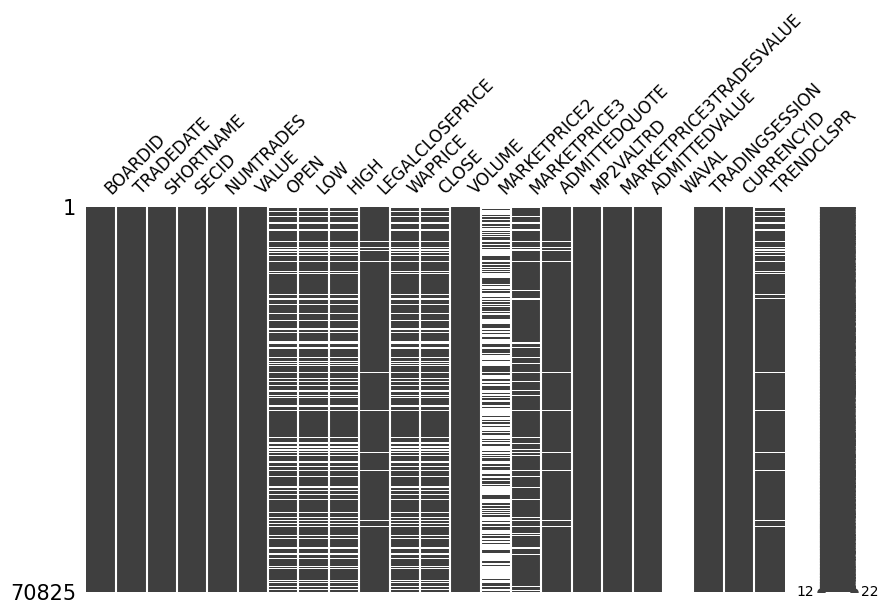

In [49]:
missingno.matrix(history_data, figsize=(10,5), fontsize=12);

In [19]:
history_data[history_data.OPEN.isna()][['TRADEDATE', 'SHORTNAME', 'SECID', 'NUMTRADES',	'VALUE', 'OPEN', 'LOW',	'HIGH',	'LEGALCLOSEPRICE', 'CLOSE', 'VOLUME']]

TRADEDATE   SHORTNAME  SECID  NUMTRADES  VALUE  OPEN  LOW  HIGH  \
2      2018-01-03     АСКО ао   ACKO          0    0.0   NaN  NaN   NaN   
7      2018-01-03  БестЭфБ ао   ALBK          0    0.0   NaN  NaN   NaN   
8      2018-01-03  АЛРОСА-Нюр   ALNU          0    0.0   NaN  NaN   NaN   
21     2018-01-03  БашИнСв ао   BISV          0    0.0   NaN  NaN   NaN   
28     2018-01-03   РН-ЗапСиб   CHGZ          0    0.0   NaN  NaN   NaN   
...           ...         ...    ...        ...    ...   ...  ...   ...   
70802  2018-12-29    ВолгЭнСб   VGSB          0    0.0   NaN  NaN   NaN   
70803  2018-12-29  ВолгЭнСб-п  VGSBP          0    0.0   NaN  NaN   NaN   
70804  2018-12-29    Варьеган   VJGZ          0    0.0   NaN  NaN   NaN   
70805  2018-12-29  Варьеган-п  VJGZP          0    0.0   NaN  NaN   NaN   
70821  2018-12-29     ТНСэнЯр   YRSB          0    0.0   NaN  NaN   NaN   

       LEGALCLOSEPRICE  CLOSE  VOLUME  
2                6.510    NaN       0  
7              107.400    NaN       0  
8           146000.000    NaN       0  
21               8.700    NaN       0  
28              35.000    NaN       0  
...                ...    ...     ...  
70802            0.780    NaN       0  
70803            0.605    NaN       0  
70804          425.000    NaN       0  
70805          284.000    NaN       0  
70821           73.000    NaN       0  

[14579 rows x 11 columns]

В таком случае у нас есть 2 варианта: убираем данные либо об акциях, которые не торговались хотя бы один день, либо об акциях, которые не торговались более некоторого количества дней.

In [7]:
num_trade_day = history_data.groupby(by="SECID", as_index=False).aggregate({"TRADEDATE": "count"}).TRADEDATE.unique()
print("Всего акций до обработки:", history_data.SECID.nunique())
print("Кол-во наблюдений за каждой акцией:", num_trade_day)

Всего акций до обработки: 287
Кол-во наблюдений за каждой акцией: [188 254  69 196  39 122  43 234 195  63 251 236 140  10  98 243]


Если акция не торгуется больше, чем 25 дней, то мы убираем такую акцию.
Кол-во акций, которое придется убрать: 148
Кол-во акций, которое остается: 168


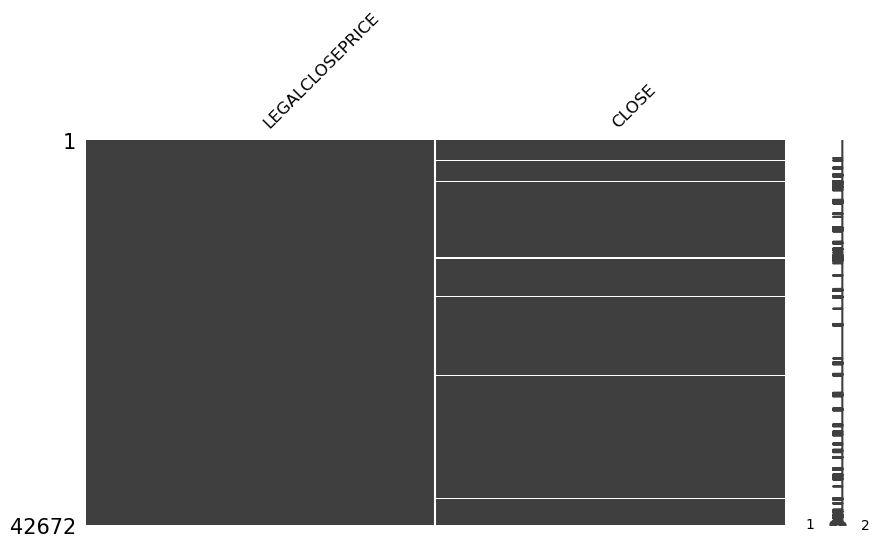

In [8]:
def get_cleaned_df(
    history_data : pd.DataFrame,
    NO_TRADES_DAY : int
    ) -> pd.DataFrame:
    
    stock_num_of_entries = history_data.groupby('SECID', as_index=False)['TRADEDATE'].count()
    stocks_to_drop_by_dates = (
                stock_num_of_entries
                # [stock_num_of_entries.TRADEDATE < (stock_num_of_entries.TRADEDATE.max() - NO_TRADES_DAY)]
                [stock_num_of_entries.TRADEDATE < stock_num_of_entries.TRADEDATE.max()]
                .SECID
                )

    no_trades_data = history_data[history_data.NUMTRADES == 0].groupby(by=["SECID"], as_index=False).count()
    stocks_to_drop_by_trades = no_trades_data[no_trades_data.NUMTRADES > NO_TRADES_DAY].SECID

    stocks_to_drop = pd.concat([stocks_to_drop_by_dates, stocks_to_drop_by_trades]).values
    data_after_drop = history_data[~history_data.SECID.isin(stocks_to_drop)]

    print(f"Если акция не торгуется больше, чем {NO_TRADES_DAY} дней, то мы убираем такую акцию.")
    print("Кол-во акций, которое придется убрать:", len(stocks_to_drop) + len(stocks_to_drop_by_dates))
    # print("Кол-во акций, которое остается:", history_data.SECID.nunique() - len(stocks_to_drop) - len(stocks_to_drop_by_dates))
    print("Кол-во акций, которое остается:", data_after_drop.SECID.nunique())
    return data_after_drop

history_data = get_cleaned_df(history_data, 25)

missingno.matrix(history_data.sort_values(by=["SECID", "TRADEDATE"])[["LEGALCLOSEPRICE", "CLOSE"]], figsize=(10,5), fontsize=12);

In [138]:
history_data.to_csv('data/history_data.csv', encoding='utf-16', index=False)

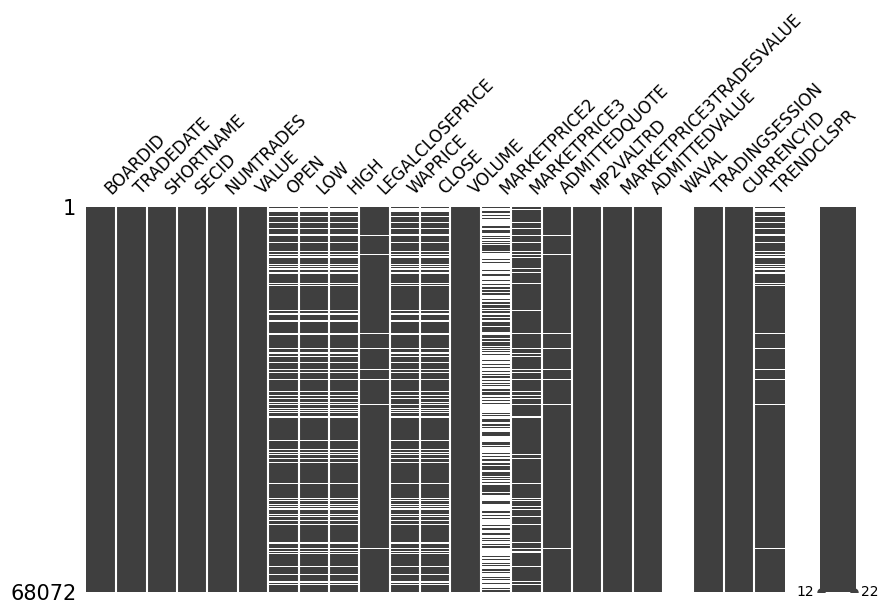

In [34]:
missingno.matrix(history_data, figsize=(10,5), fontsize=12);

In [9]:
COLUMNS_TO_DROP = [
    "BOARDID",
    "SHORTNAME",
    "VALUE",
    "OPEN",
    "LOW",
    "HIGH",
    "WAPRICE",
    "MARKETPRICE2",
    "MARKETPRICE3",
    "ADMITTEDQUOTE",
    "MP2VALTRD",
    "MARKETPRICE3TRADESVALUE",
    "ADMITTEDVALUE",
    "WAVAL",
    "TRADINGSESSION",
    "CURRENCYID",
]
history_data = history_data.drop(columns=COLUMNS_TO_DROP)
history_data.sample(5, random_state=SEED)

TRADEDATE SECID  NUMTRADES  LEGALCLOSEPRICE      CLOSE    VOLUME  \
50181  2018-09-17  KUZB         63           0.0096     0.0096   9980000   
17640  2018-04-04  MSNG        891           2.8880     2.8880  11570000   
14865  2018-03-21  PRTK         48         103.8000   103.8000     17400   
41431  2018-08-02  TRCN         13        4445.0000  4440.0000        47   
64525  2018-11-29  CHEP          5         111.6000   111.6000       500   

       TRENDCLSPR  
50181       -6.80  
17640       -1.16  
14865        0.87  
41431       -1.55  
64525        1.27

In [10]:
data_with_return = get_df_with_return(history_data, first_day_value=0.0)
data_with_return.sort_values(by=["SECID", "TRADEDATE"])

TRADEDATE SECID  NUMTRADES  LEGALCLOSEPRICE   CLOSE    VOLUME  \
3      2018-01-03  AFKS       5071           12.350  12.350  20687500   
286    2018-01-04  AFKS       4362           12.385  12.385  14880200   
569    2018-01-05  AFKS       3666           12.390  12.390  11072000   
852    2018-01-09  AFKS       9167           12.715  12.715  30905600   
1135   2018-01-10  AFKS       4446           12.700  12.700  11774300   
...           ...   ...        ...              ...     ...       ...   
69734  2018-12-25  ZVEZ         15            4.650   4.620     26000   
70008  2018-12-26  ZVEZ          6            4.700   4.700      6000   
70280  2018-12-27  ZVEZ          7            4.650   4.650     20000   
70552  2018-12-28  ZVEZ         21            4.660   4.660     60000   
70824  2018-12-29  ZVEZ         19            4.690   4.690     34000   

       TRENDCLSPR    RETURN  
3            2.15  0.000000  
286          0.28  0.002830  
569          0.04  0.000404  
852          2.62  0.025893  
1135        -0.12 -0.001180  
...           ...       ...  
69734       -0.65  0.000000  
70008        1.73  0.010695  
70280       -1.06 -0.010695  
70552        0.22  0.002148  
70824        0.64  0.006417  

[42672 rows x 8 columns]

In [11]:
data_with_return = get_df_with_mean_std_return(data_with_return)

stock_characteristics = data_with_return[['SECID', 'RETURN', 'MEAN_RETURN', 'STD_RETURN']].groupby('SECID').first().reset_index().drop(columns=['RETURN'])
stock_characteristics

SECID  MEAN_RETURN  STD_RETURN
0    AFKS    -0.001710    0.016348
1    AFLT    -0.001290    0.019499
2    AGRO     0.001292    0.012210
3    AKRN     0.000713    0.008926
4    ALRS     0.001036    0.016165
..    ...          ...         ...
163  WTCM     0.000033    0.023961
164  YKEN    -0.000569    0.021877
165  YNDX    -0.000027    0.024079
166  ZILL    -0.000842    0.023495
167  ZVEZ     0.000163    0.041932

[168 rows x 3 columns]

Посмотрим сколько дней доходность 0.

In [12]:
data_with_return[data_with_return.RETURN == 0.0]\
    .groupby(by="SECID", as_index=False)\
    .aggregate({"RETURN":"count"})\
    .rename(columns={"RETURN": "DAYS OF ZERO RETURN"})\
    .sort_values(by="DAYS OF ZERO RETURN", ascending=False)

SECID  DAYS OF ZERO RETURN
97    OPIN                  111
7     AVAZ                   75
8    AVAZP                   72
112   RLMN                   71
147   TNSE                   70
..     ...                  ...
85    MTLR                    2
118   RSTI                    1
126  SBERP                    1
64    MAGN                    1
139   TATN                    1

[168 rows x 2 columns]

Так как таких дней не очень много, поэтому пока оставим эти данные.

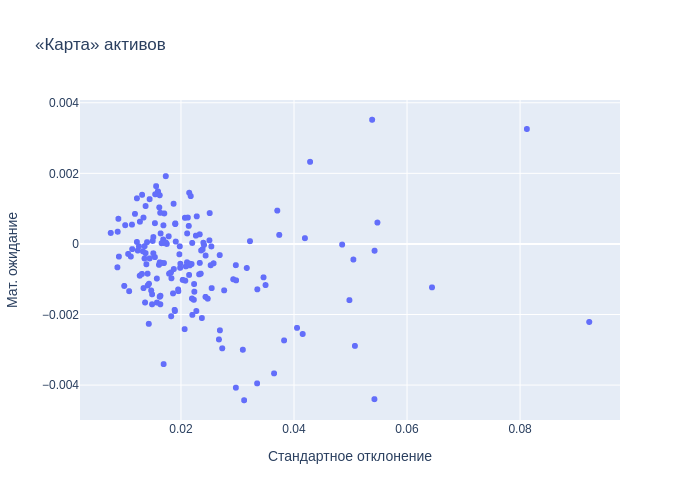

In [69]:
fig = px.scatter(stock_characteristics, x="STD_RETURN", y="MEAN_RETURN",
                title="«Карта» активов",
                labels={
                     "STD_RETURN": "Стандартное отклонение",
                     "MEAN_RETURN": "Мат. ожидание"})
fig.show("png")

Средняя доходность большей части активов колеблется в пределах от -0.002 до 0.002, риск - от 0.01 до 0.025. Тем не менее, достаточно много активов обладают высоким риском при невысокой доходности (но есть исключения). Больше половины акций обладают отрицательной доходностью.

In [14]:
stock_characteristics[stock_characteristics.STD_RETURN > 0.04].sort_values(by='STD_RETURN', ascending=False)

SECID  MEAN_RETURN  STD_RETURN
130   SIBG    -0.002212    0.092239
83    MSST     0.003257    0.081203
112   RLMN    -0.001231    0.064417
138   TANL     0.000605    0.054761
123   RUGR    -0.000192    0.054252
32    FTRE    -0.004399    0.054232
43    IRKT     0.003519    0.053827
19   CLSBP    -0.002890    0.050778
22    DASB    -0.000442    0.050507
18    CLSB    -0.001593    0.049807
55   KZOSP    -0.000018    0.048521
25    DVEC     0.002326    0.042845
167   ZVEZ     0.000163    0.041932
28    ENPL    -0.002552    0.041539
113  RLMNP    -0.002379    0.040536

Посмотрим на некоторые компании с высоким риском и высокой доходностью:

IRKT - ПАО "Яковлев", производство гражданских самолетов\
MSST - ОАО "Мультсистема", коммунальные услуги\
DVEC - ПАО "Дальневосточная энергетическая компания", энергетическая сбытовая компания

Компании с высоким риском и низкой (отрицательной) доходностью:

SIBG - ПАО «Айс стим Рус», продукты сублимационной сушки и пищевых компонентов\
RLMN - ПАО «Группа Компаний „Роллман“», химикаты\
RUGR - "РУСГРЭЙН ХОЛДИНГ", еда и табачные изделия

# Задание 3

Рассмотрите	портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

In [15]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16')
df.sample(5, random_state=SEED)

TRADEDATE SECID  NUMTRADES  LEGALCLOSEPRICE      CLOSE    VOLUME  \
30125  2018-09-17  VZRZ         37         431.0000  431.00000       534   
10497  2018-04-04  TGKN         34           0.0053    0.00536  98000000   
8842   2018-03-21  MSST         50           1.1200    1.12000     24400   
24844  2018-08-02  MSRS        113           0.7260    0.72800   4320000   
38823  2018-11-29  RUGR       1754           6.2800    6.28000    590660   

       TRENDCLSPR    RETURN  
30125       -1.15 -0.011534  
10497        2.88  0.017127  
8842         0.00  0.004474  
24844        0.28  0.000000  
38823        0.88  0.008797

In [16]:
N = df.SECID.nunique()
equal_ratios = [1/N]*N
portfolio_expected_return = get_portfolio_expected_return(df, equal_ratios)
portfolio_std = get_portfolio_std(df, equal_ratios)
print(f"Ожидаемая доходность портфеля с равными долями капитала: {portfolio_expected_return:.5f}")
print(f"Стандартное отклонение портфеля с равными долями капитала: {portfolio_std:.5f}")

Ожидаемая доходность портфеля с равными долями капитала: -0.00053
Стандартное отклонение портфеля с равными долями капитала: 0.00708


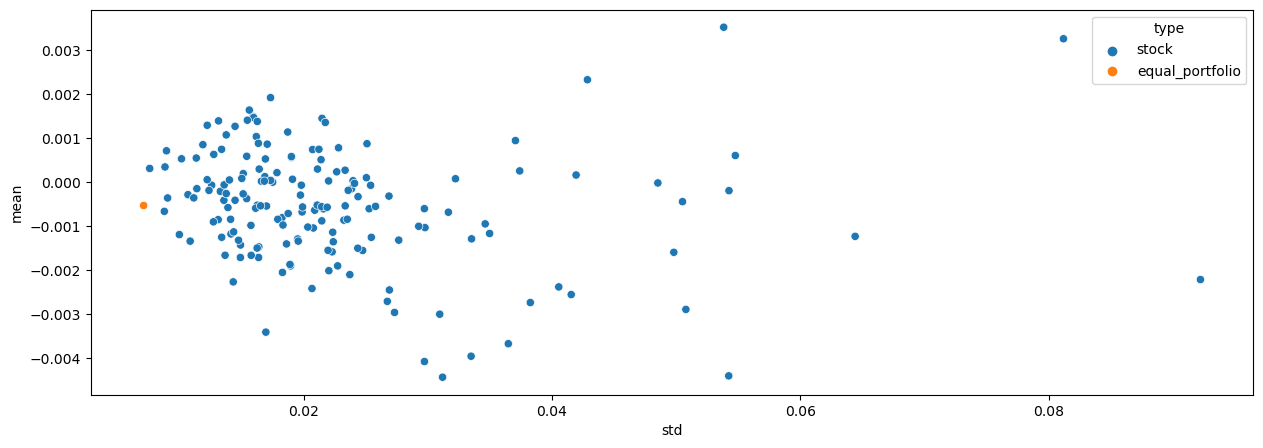

In [17]:
stocks_statistics = df.groupby(by="SECID").aggregate({"RETURN": ["mean", "std"]})["RETURN"]
stocks_statistics["type"] = "stock"

equal_portfolio = pd.DataFrame({"mean": [portfolio_expected_return], "std": [portfolio_std], "type": ["equal_portfolio"]})
stocks_statistics = pd.concat([stocks_statistics, equal_portfolio])

plt.figure(figsize=(15, 5))
sns.scatterplot(data=stocks_statistics, x="std", y="mean", hue="type");

Создадим несколько рандомных портфелей. В них будут находиться все акции, но уже с разными долями.

In [18]:
NUM_RANDOM_PORTFOLIO = 5

random_portfolio_df = {"mean": [], "std": [], "type": ["random_portfolio"] * NUM_RANDOM_PORTFOLIO}
for _ in range(NUM_RANDOM_PORTFOLIO):
    ratios = np.random.dirichlet(np.ones(N)).tolist()
    ex_return = get_portfolio_expected_return(df, ratios)
    ex_std = get_portfolio_std(df, ratios)
    random_portfolio_df["mean"].append(ex_return)
    random_portfolio_df["std"].append(ex_std)
random_portfolio_df = pd.DataFrame(random_portfolio_df)

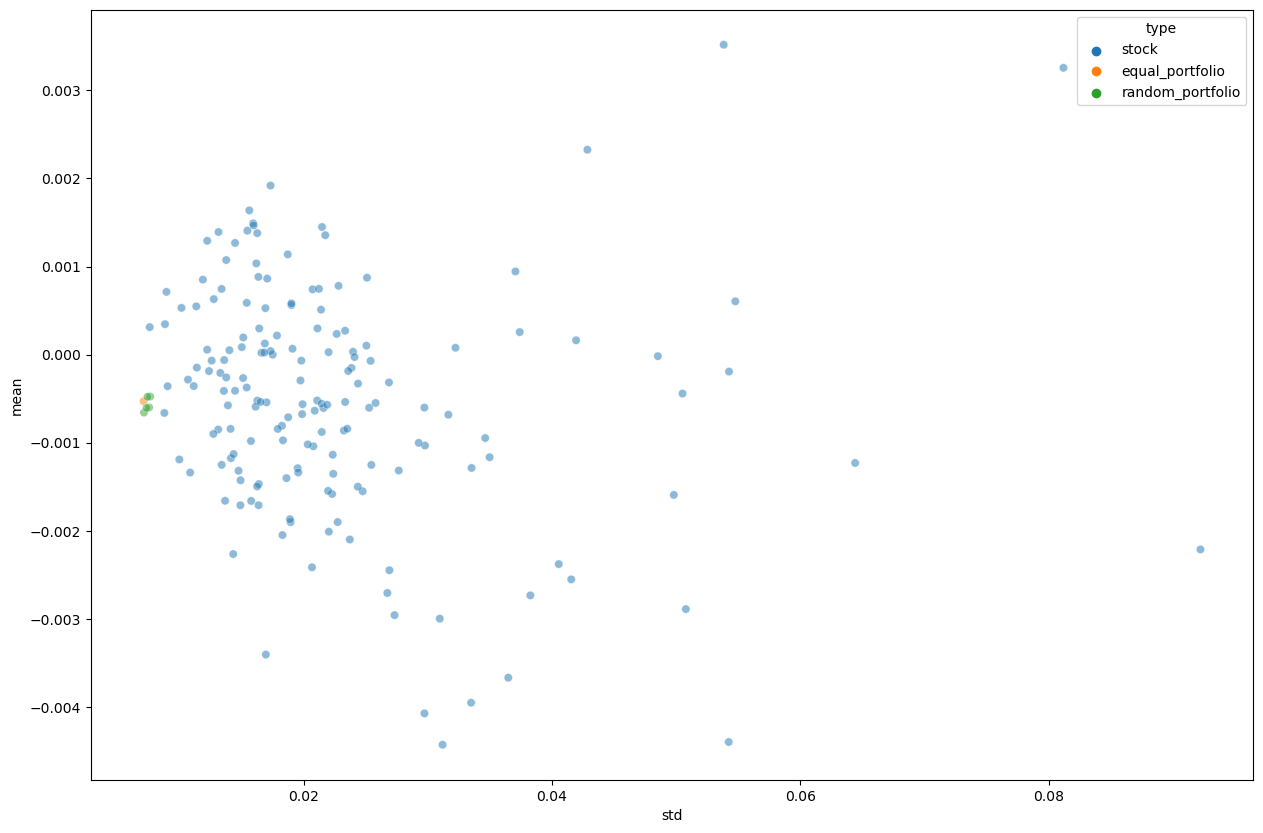

In [19]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=pd.concat([stocks_statistics, random_portfolio_df]), x="std", y="mean", hue="type", alpha=0.5);

Конечно, такие портфели концентрируются около портфеля с разными долями.  

# Задание 4
Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E).
Дайте характеристику индексу рынка.

Индекс МосБиржи - ценовой взвешенный по рыночной капитализации композитный индекс российского фондового рынка, включающие наиболее ликвидные акции крупнейших и динамично развивающихся российских эмитентов, виды экономической деятельности которых относятся к основным секторам экономики.

In [20]:
history_index_data = history_index_data[['SECID', 'TRADEDATE', 'NAME',	'CLOSE', 'OPEN', 'HIGH', 'LOW',	'VALUE']]
history_index_data

SECID   TRADEDATE             NAME    CLOSE     OPEN     HIGH      LOW  \
0    IMOEX  2018-01-03  Индекс МосБиржи  2152.97  2111.24  2152.97  2111.24   
1    IMOEX  2018-01-04  Индекс МосБиржи  2197.60  2153.87  2197.60  2153.87   
2    IMOEX  2018-01-05  Индекс МосБиржи  2207.41  2196.69  2207.41  2188.35   
3    IMOEX  2018-01-09  Индекс МосБиржи  2225.39  2211.40  2242.87  2211.40   
4    IMOEX  2018-01-10  Индекс МосБиржи  2232.27  2227.33  2233.63  2213.77   
..     ...         ...              ...      ...      ...      ...      ...   
249  IMOEX  2018-12-25  Индекс МосБиржи  2290.86  2318.43  2318.43  2258.27   
250  IMOEX  2018-12-26  Индекс МосБиржи  2308.85  2291.98  2315.98  2291.98   
251  IMOEX  2018-12-27  Индекс МосБиржи  2327.81  2316.66  2340.63  2316.66   
252  IMOEX  2018-12-28  Индекс МосБиржи  2358.50  2329.96  2369.24  2329.96   
253  IMOEX  2018-12-29  Индекс МосБиржи  2369.33  2359.38  2370.00  2357.10   

            VALUE  
0    2.107610e+10  
1    3.653125e+10  
2    2.598557e+10  
3    4.438950e+10  
4    4.008192e+10  
..            ...  
249  1.856123e+10  
250  1.494648e+10  
251  2.811124e+10  
252  2.367390e+10  
253  5.558291e+09  

[254 rows x 8 columns]

In [21]:
index_data_with_return = get_df_with_return(history_index_data, price_name='CLOSE', first_day_value=0.0)
index_data_characteristics = get_df_with_mean_std_return(index_data_with_return[['SECID', 'RETURN']].copy()).groupby('SECID').first().reset_index().drop(columns=['RETURN'])
index_data_characteristics

SECID  MEAN_RETURN  STD_RETURN
0  IMOEX     0.000377    0.010814

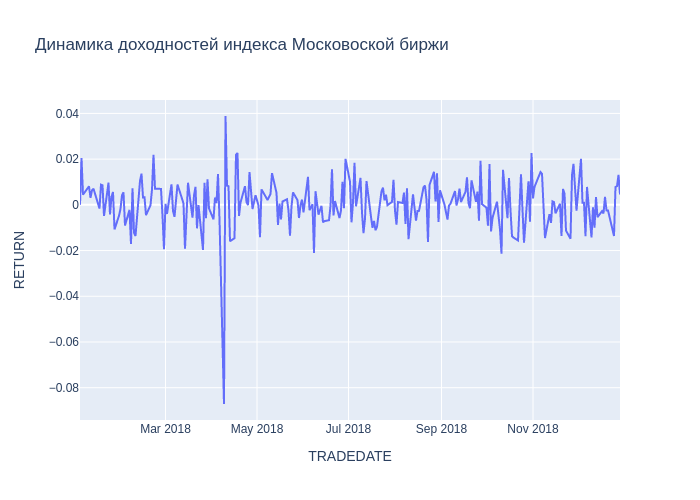

In [70]:
fig = px.line(index_data_with_return, x='TRADEDATE', y='RETURN', title='Динамика доходностей индекса Московоской биржи')
fig.show("png")

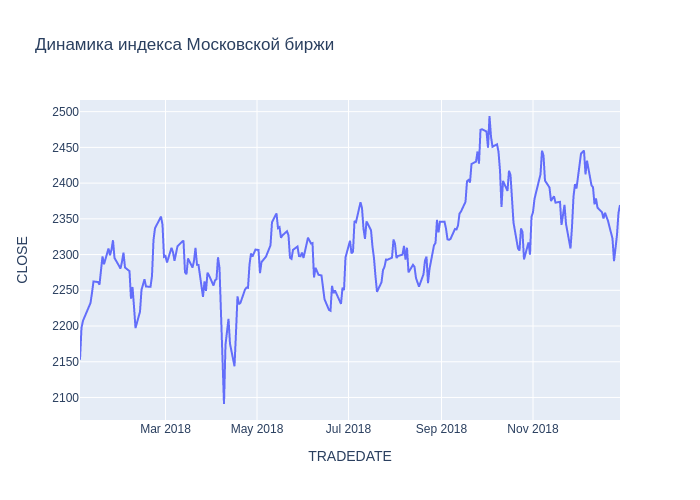

In [71]:
fig = px.line(index_data_with_return, x='TRADEDATE', y='CLOSE', title='Динамика индекса Московской биржи')
fig.show("png")

В целом индекс показывает положительную динамику. В апреле наблюдаем резкое падение мндекса - повлияло ожесточение санкций США. Осенью индекс стал расти из-за повышения цен на нефть, соответсвенно стали расти акций "Газпрома", "Лукойла", "Роснефти" и других связанных с нефтью компаний. 

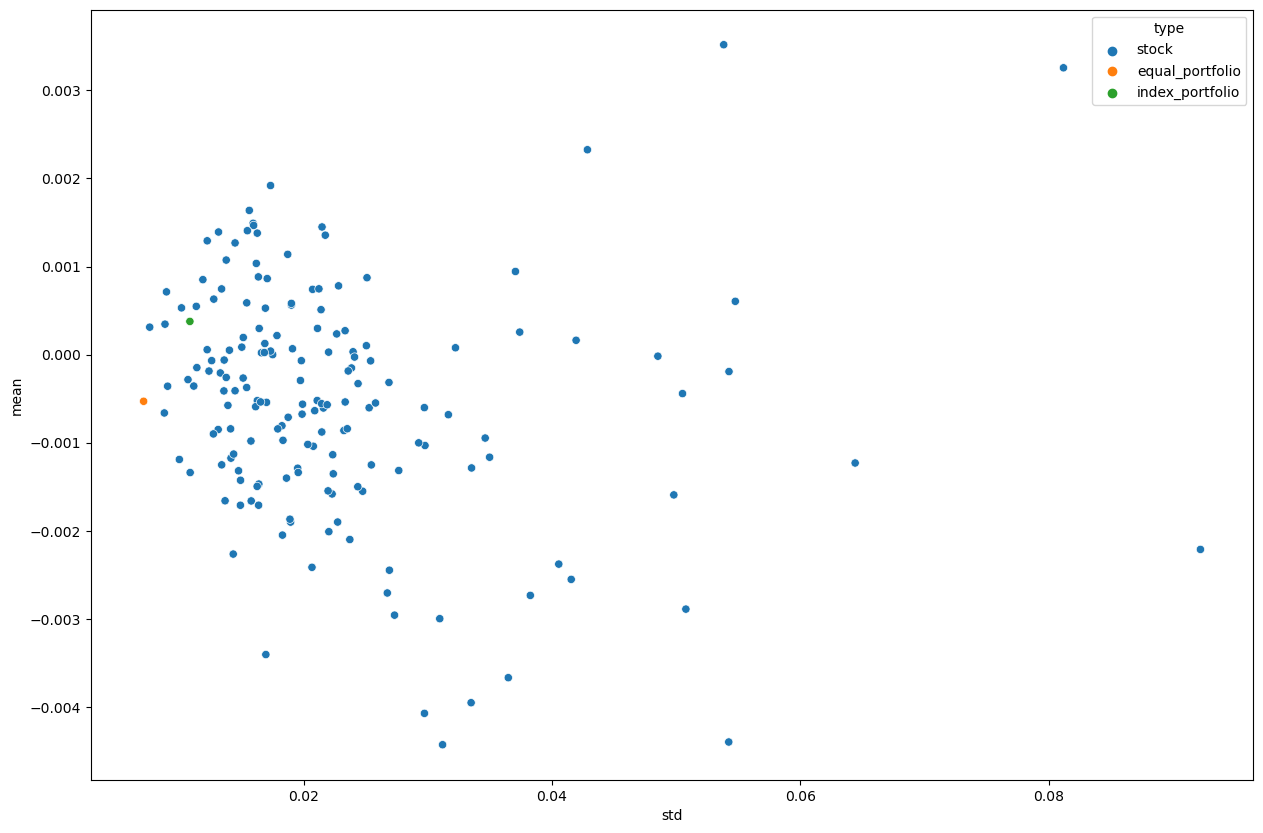

In [24]:
index_portfolio_df = {
    "mean": [index_data_characteristics['MEAN_RETURN'].values[0]], 
    "std": [index_data_characteristics['STD_RETURN'].values[0]], 
    "type": ["index_portfolio"]
}
index_portfolio_df = pd.DataFrame(index_portfolio_df)

plt.figure(figsize=(15, 10))
sns.scatterplot(data=pd.concat([stocks_statistics, index_portfolio_df]), x="std", y="mean", hue="type");

Видно, что индекс биржи имеет более высокую доходность и чуть больший риск, чем портфель с равными долями.

# Задание 5

Задайте	уровень риска и оцените VaR	(ValueatRisk	= Сумма под Риском для случайных величин	Потери = - Доходности) для активов вашего	рынка. Какой из активов наиболее	предпочтителен по этой характеристике? Где он расположен на карте активов?	Дайте характеристику VaR	портфеля с равными долями и индекса	рынка.

In [25]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16')

In [26]:
VaR_9 = lambda x: get_VaR(x, 0.9)
VaR_95 = lambda x: get_VaR(x, 0.95)
df_with_VaR = df.groupby(by="SECID", as_index=False)\
                    .agg(
                        var_1=pd.NamedAgg(column="RETURN", aggfunc=VaR_9),
                        var_2=pd.NamedAgg(column="RETURN", aggfunc=VaR_95),
                    )\
                    .rename(columns={"var_1": "VaR (0.9)", "var_2": "VaR (0.95)"})

In [27]:
# Актив с самой большой возможной потерей
max_VaR = df_with_VaR.sort_values(by="VaR (0.9)", ascending=False).head(1)
max_VaR_name = df_with_VaR.sort_values(by="VaR (0.9)", ascending=False).head(1).SECID.values[0]
max_VaR

SECID  VaR (0.9)  VaR (0.95)
130  SIBG   0.076145    0.109182

In [28]:
# Актив с наименьшей возможной потерей
min_VaR = df_with_VaR.sort_values(by="VaR (0.9)").head(1)
min_VaR_name = df_with_VaR.sort_values(by="VaR (0.9)").head(1).SECID.values[0]
min_VaR

SECID  VaR (0.9)  VaR (0.95)
159  VSMO   0.006897    0.010238

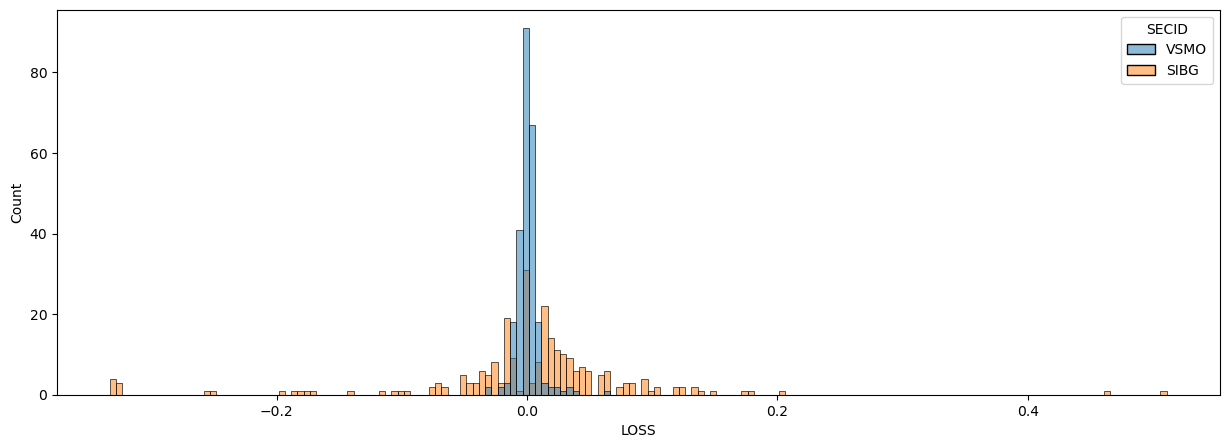

In [29]:
plt.figure(figsize=(15, 5))
df_loss = df[df.SECID.isin([max_VaR_name, min_VaR_name])]
df_loss = df_loss.assign(LOSS=-df_loss.RETURN)

sns.histplot(data=df_loss, x="LOSS", hue="SECID");

Видно, что актив с наименьшей возможной потерей концентрируется вокруг нуля. В это же время актив с наибольшим VaR более размашист. 

VaR портфеля с одинаковыми доля (γ = 0.90): 0.000013
VaR портфеля с одинаковыми доля (γ = 0.95): 0.000017


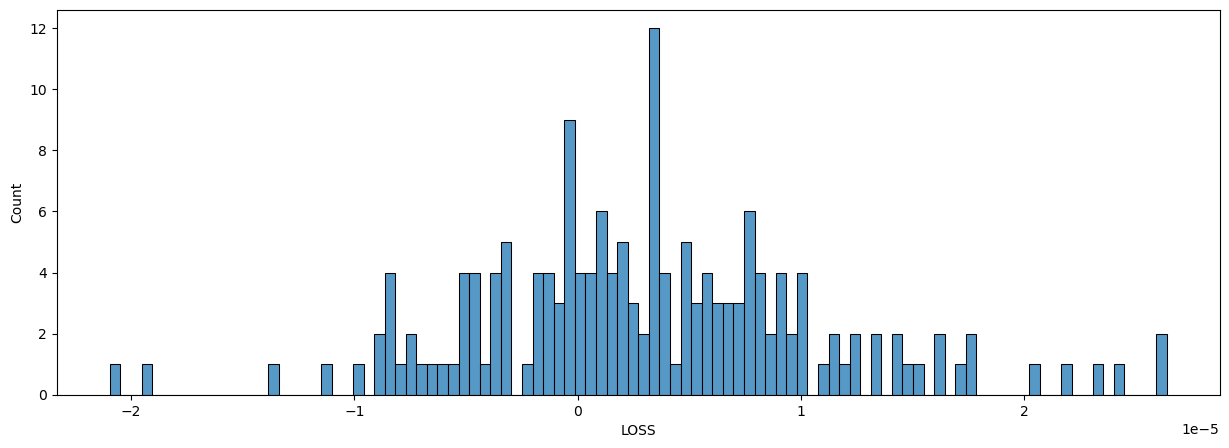

In [31]:
N = df.SECID.nunique()
equal_portfolio_returns = df.groupby(by="SECID", as_index=False).agg({"RETURN": "mean"}).RETURN / N
VaR_eq_p_9 = get_VaR(equal_portfolio_returns)
VaR_eq_p_95 = get_VaR(equal_portfolio_returns, gamma=0.95)
print(f"VaR портфеля с одинаковыми доля (γ = 0.90): {VaR_eq_p_9:.6f}")
print(f"VaR портфеля с одинаковыми доля (γ = 0.95): {VaR_eq_p_95:.6f}")

plt.figure(figsize=(15, 5))
ax = sns.histplot(x=-equal_portfolio_returns, bins=100);
ax.set(xlabel="LOSS")
plt.show();

Возможные потери портфеля с одинаковыми долями очень небольшие.

In [32]:
stocks_statistics = pd.read_csv("data/stocks_statistics.csv", encoding='UTF-16', index_col=[0])

stocks_statistics.at[min_VaR_name, "type"] = "min_VaR"
stocks_statistics.at[max_VaR_name, "type"] = "max_VaR"

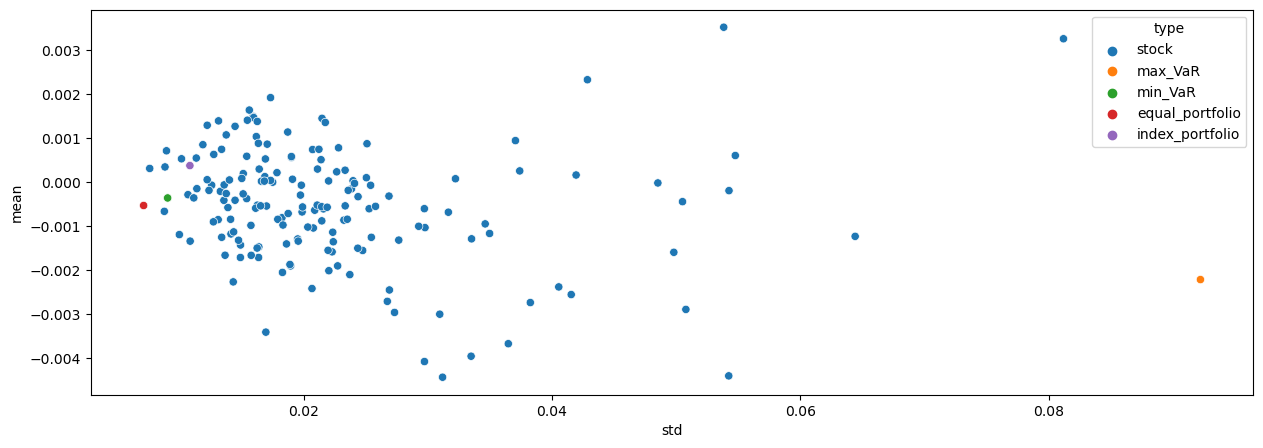

In [33]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=pd.concat([stocks_statistics, index_portfolio_df]), x="std", y="mean", hue="type");

# Задание 6

Выберите	несколько интересных (значимых) активов	рынка. Можно ли считать наблюдаемые	доходности (объемы продаж) конкретного	актива повторной выборкой из некоторого	распределения (белый шум)? Поищите	научные подходы к ответу на этот вопрос	(проверка гипотезы о случайности,	Ивченко Г.И. Медведев Ю.И. Введение в	математическую статистику)

In [34]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16', parse_dates=["TRADEDATE"])
df.sample(5, random_state=SEED)

TRADEDATE SECID  NUMTRADES  LEGALCLOSEPRICE      CLOSE    VOLUME  \
30125 2018-09-17  VZRZ         37         431.0000  431.00000       534   
10497 2018-04-04  TGKN         34           0.0053    0.00536  98000000   
8842  2018-03-21  MSST         50           1.1200    1.12000     24400   
24844 2018-08-02  MSRS        113           0.7260    0.72800   4320000   
38823 2018-11-29  RUGR       1754           6.2800    6.28000    590660   

       TRENDCLSPR    RETURN  
30125       -1.15 -0.011534  
10497        2.88  0.017127  
8842         0.00  0.004474  
24844        0.28  0.000000  
38823        0.88  0.008797

In [35]:
significant_stocks = df.groupby(by="SECID", as_index=False).agg({"VOLUME": "median"}).sort_values(by="VOLUME", ascending=False).head(5).SECID
significant_stocks

160    VTBR
141    TGKA
30     FEES
40     HYDR
142    TGKB
Name: SECID, dtype: object

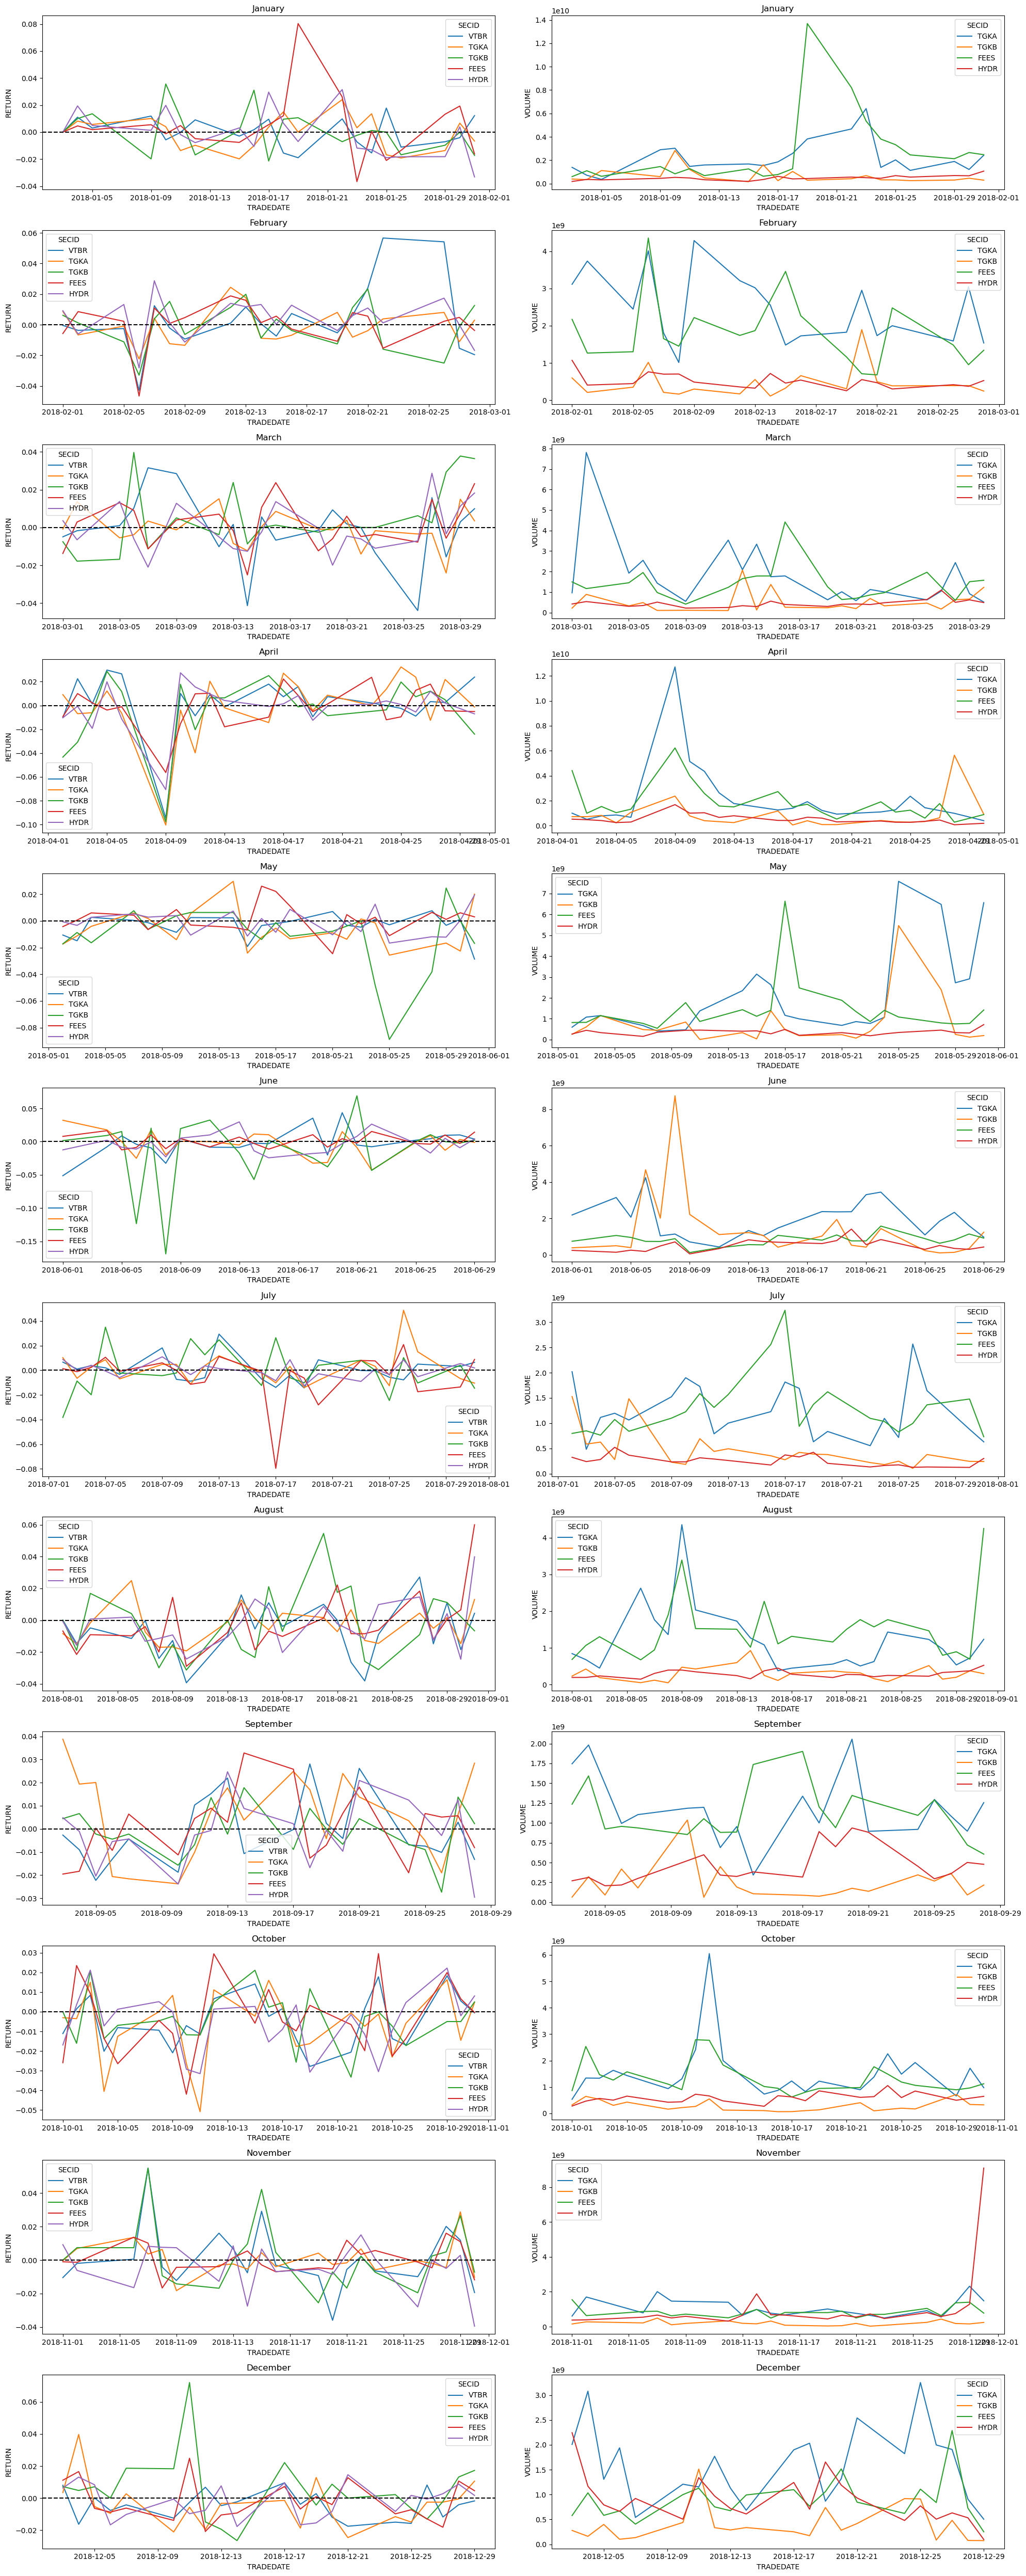

In [37]:
df_with_month = df.assign(MONTH=df.TRADEDATE.dt.month_name())

fig, ax = plt.subplots(12, 2, figsize=(20, 50))

for i, month in enumerate(df_with_month.MONTH.unique()):
    df_month_window = df_with_month[df_with_month.MONTH == month]
    sns.lineplot(data=df_month_window[df_month_window.SECID.isin(significant_stocks)], x="TRADEDATE", y="RETURN", hue="SECID", ax=ax[i][0]);
    sns.lineplot(data=df_month_window[df_month_window.SECID.isin(significant_stocks.tail(4))], x="TRADEDATE", y="VOLUME", hue="SECID", ax=ax[i][1]);
    ax[i][0].set_title(month)
    ax[i][1].set_title(month)
    ax[i][0].axhline(0, ls='--', color='black')
fig.tight_layout();

### Воспользуемся критерием автокорреляции

In [38]:
ALPHA = 0.05
SHIFT = 10

In [39]:
def autocorrelation_criterion(
    returns: pd.Series,
    alpha: float=0.05,
    shift: int=1,
) -> dict:
    N = len(returns)
    shift_returns = np.roll(returns, shift)
    numerator = N * np.sum(list(map(lambda x,y: x*y, returns, shift_returns))) - np.power(sum(returns), 2)
    denominator = N * np.sum(list(map(lambda x: x*x, returns))) - np.power(np.sum(returns), 2)
    coef_cor = numerator / denominator
    
    e = - 1 / (N-1)
    d = N * (N - 3) / ((N + 1) * np.power(N - 1, 2))
    
    cr = abs(coef_cor - e) / np.sqrt(d)
    q = scipy.stats.norm.ppf(1 - alpha/2)
    isTrend = cr > q
    return {'coef_criteria': cr, "trend": isTrend}

Проверяется гипотеза о том, что все выборочные значения принадлежат к одной генеральной совокупности со средним:



против конкурирующей гипотезы о наличии тренда



Если выборка значений случайна, то значение каждого ее элемента не должно зависеть от величины предшествующего и последующего членов. Для проверки этой независимости используется статистика:

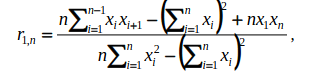

Величину r можно считать распределенной асимптотически нормально со средним и дисперсией:

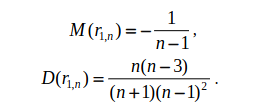

Поэтому в качестве критерия случайности может рассматриваться нормализованная статистика:

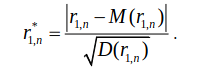

Гипотеза о случайности отклоняется при:

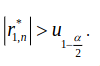

In [40]:
isTrend = False
print(f"Проверка тренда (диапозон 1 год == {df.TRADEDATE.nunique()} наблюдений) критерием автокорреляции на доходностях.")
for stock in significant_stocks:
    criterion_dict = autocorrelation_criterion(df[df.SECID == stock].RETURN, ALPHA, SHIFT)
    if criterion_dict['trend']:
        print("Есть тренд у актива:", stock)
        isTrend = True
        
if not isTrend:
    print("Тренда нет")

isTrend = False
print(f"Проверка тренда (диапозон 1 год == {df.TRADEDATE.nunique()} наблюдений) критерием автокорреляции на объеме.") 
for stock in significant_stocks:
    criterion_dict = autocorrelation_criterion(df[df.SECID == stock].VOLUME, ALPHA, SHIFT)
    if criterion_dict['trend']:
        print("Есть тренд у актива:", stock)
        isTrend = True
        
if not isTrend:
    print("Тренда нет")

Проверка тренда (диапозон 1 год == 254 наблюдений) критерием автокорреляции на доходностях.
Есть тренд у актива: TGKB
Проверка тренда (диапозон 1 год == 254 наблюдений) критерием автокорреляции на объеме.
Тренда нет


In [41]:
# Проверим каждый месяц
trend_dict = {"month": [], "stock": [], "isTrend": [], "observations": []}
for month in df_with_month.MONTH.unique():
    for stock in significant_stocks:
        temp_df = df_with_month[(df_with_month.SECID == stock) & (df_with_month.MONTH == month)]
        cr = autocorrelation_criterion(temp_df.RETURN, ALPHA, SHIFT)
        trend_dict["month"].append(month)
        trend_dict["stock"].append(stock)
        trend_dict["isTrend"].append(cr["trend"])
        trend_dict["observations"].append(temp_df.TRADEDATE.nunique())
        
trend_df = pd.DataFrame(trend_dict)
print("RETURNS")
trend_df[(trend_df.isTrend == True) & (trend_df.observations > 10)]

RETURNS


month stock  isTrend  observations
1    January  TGKA     True            20
58  December  HYDR     True            21

In [42]:
# Проверим каждый месяц
trend_dict = {"month": [], "stock": [], "isTrend": [], "observations": []}
for month in df_with_month.MONTH.unique():
    for stock in significant_stocks:
        temp_df = df_with_month[(df_with_month.SECID == stock) & (df_with_month.MONTH == month)]
        cr = autocorrelation_criterion(temp_df.VOLUME, ALPHA, SHIFT)
        trend_dict["month"].append(month)
        trend_dict["stock"].append(stock)
        trend_dict["isTrend"].append(cr["trend"])
        trend_dict["observations"].append(temp_df.TRADEDATE.nunique())
        
trend_df = pd.DataFrame(trend_dict)
print("VOLUME")
trend_df[(trend_df.isTrend == True) & (trend_df.observations > 10)]

VOLUME


month stock  isTrend  observations
4     January  TGKB     True            20
9    February  TGKB     True            19
13      March  HYDR     True            21
14      March  TGKB     True            21
27       June  FEES     True            21
31       July  TGKA     True            22
34       July  TGKB     True            22
39     August  TGKB     True            23
42  September  FEES     True            20
43  September  HYDR     True            20
44  September  TGKB     True            20
48    October  HYDR     True            23
49    October  TGKB     True            23
51   November  TGKA     True            21
52   November  FEES     True            21
58   December  HYDR     True            21
59   December  TGKB     True            21

### Тест тренда Манна-Кендалла

Т.к. автокорреляция не считается достаточно мощным критерием, то еще посмотрим тест Манна-Кендалла

In [43]:
print('RETURNS\n')
trend_dict = {"stock": [], "trend": []}
for stock in significant_stocks:
    result = mk.original_test(df[df.SECID == stock].RETURN, alpha=ALPHA)
    trend_dict["stock"].append(stock)
    trend_dict["trend"].append(getattr(result, "trend"))

pd.DataFrame(trend_dict)

RETURNS



stock       trend
0  VTBR  decreasing
1  TGKA    no trend
2  FEES    no trend
3  HYDR    no trend
4  TGKB    no trend

In [44]:
print('VOLUME\n')
trend_dict = {"stock": [], "trend": []}
for stock in significant_stocks:
    result = mk.original_test(df[df.SECID == stock].VOLUME, alpha=ALPHA)
    trend_dict["stock"].append(stock)
    trend_dict["trend"].append(getattr(result, "trend"))

pd.DataFrame(trend_dict)

VOLUME



stock       trend
0  VTBR  decreasing
1  TGKA  decreasing
2  FEES  decreasing
3  HYDR  increasing
4  TGKB  decreasing

In [46]:
# Проверим каждый месяц
trend_dict = {"month": [], "stock": [], "isTrend": [], "observations": []}
for month in df_with_month.MONTH.unique():
    for stock in significant_stocks:
        temp_df = df_with_month[(df_with_month.SECID == stock) & (df_with_month.MONTH == month)]
        cr = mk.original_test(temp_df.VOLUME, alpha=ALPHA)
        trend_dict["month"].append(month)
        trend_dict["stock"].append(stock)
        trend_dict["isTrend"].append(getattr(cr, "trend"))
        trend_dict["observations"].append(temp_df.TRADEDATE.nunique())
        
trend_df = pd.DataFrame(trend_dict)
print("VOLUME")
trend_df[(trend_df.isTrend != "no trend")]

VOLUME


month stock     isTrend  observations
2     January  FEES  increasing            20
3     January  HYDR  increasing            20
11      March  TGKA  decreasing            21
13      March  HYDR  increasing            21
15      April  VTBR  decreasing            22
17      April  FEES  decreasing            22
18      April  HYDR  decreasing            22
21        May  TGKA  increasing            21
30       July  VTBR  decreasing            22
33       July  HYDR  decreasing            22
34       July  TGKB  decreasing            22
43  September  HYDR  increasing            20
53   November  HYDR  increasing            21
58   December  HYDR  decreasing            21

# Задание 7
Выберите несколько интересных (значимых) активов рынка из разных
производственных секторов. В предположении, что наблюдаемые доходности
(объемы продаж) являются повторной выборкой из некоторого распределения
исследовать (выборочно) распределения доходностей и объемов продаж выбранных
активов. Сделать выводы.

Выберем компании, которые входят в индекс голубых фишек МосБиржи на 2018 (индекс рассчитывается на основании цен сделок с акциями 15-ти наиболее ликвидных акций российского фондового рынка или так называемых "голубых фишек"):\
\
GAZP - ПАО "Газпром", Энергетические и минеральные ресурсы\
SBER - ПАО "СберБанк России", финансы, банки\
GMKN - ПАО ГМК "Норильский Никель", Несырьевые полезные ископаемые\
MGNT - ПАО "Магнит", розничная торговля, продуктовая розница\
IRAO - ПАО Интер РАО ЕЭС, коммунальные услуги, электроэнергетика\
YNDX - Yandex NV, технологии, интернет-сервисы и ПО\
\
Сначала построим гистограммы распределения доходностей и объёмов продаж:

In [47]:
stocks_to_analyze = ['GAZP', 'SBER', 'GMKN', 'MGNT', 'IRAO', 'YNDX']

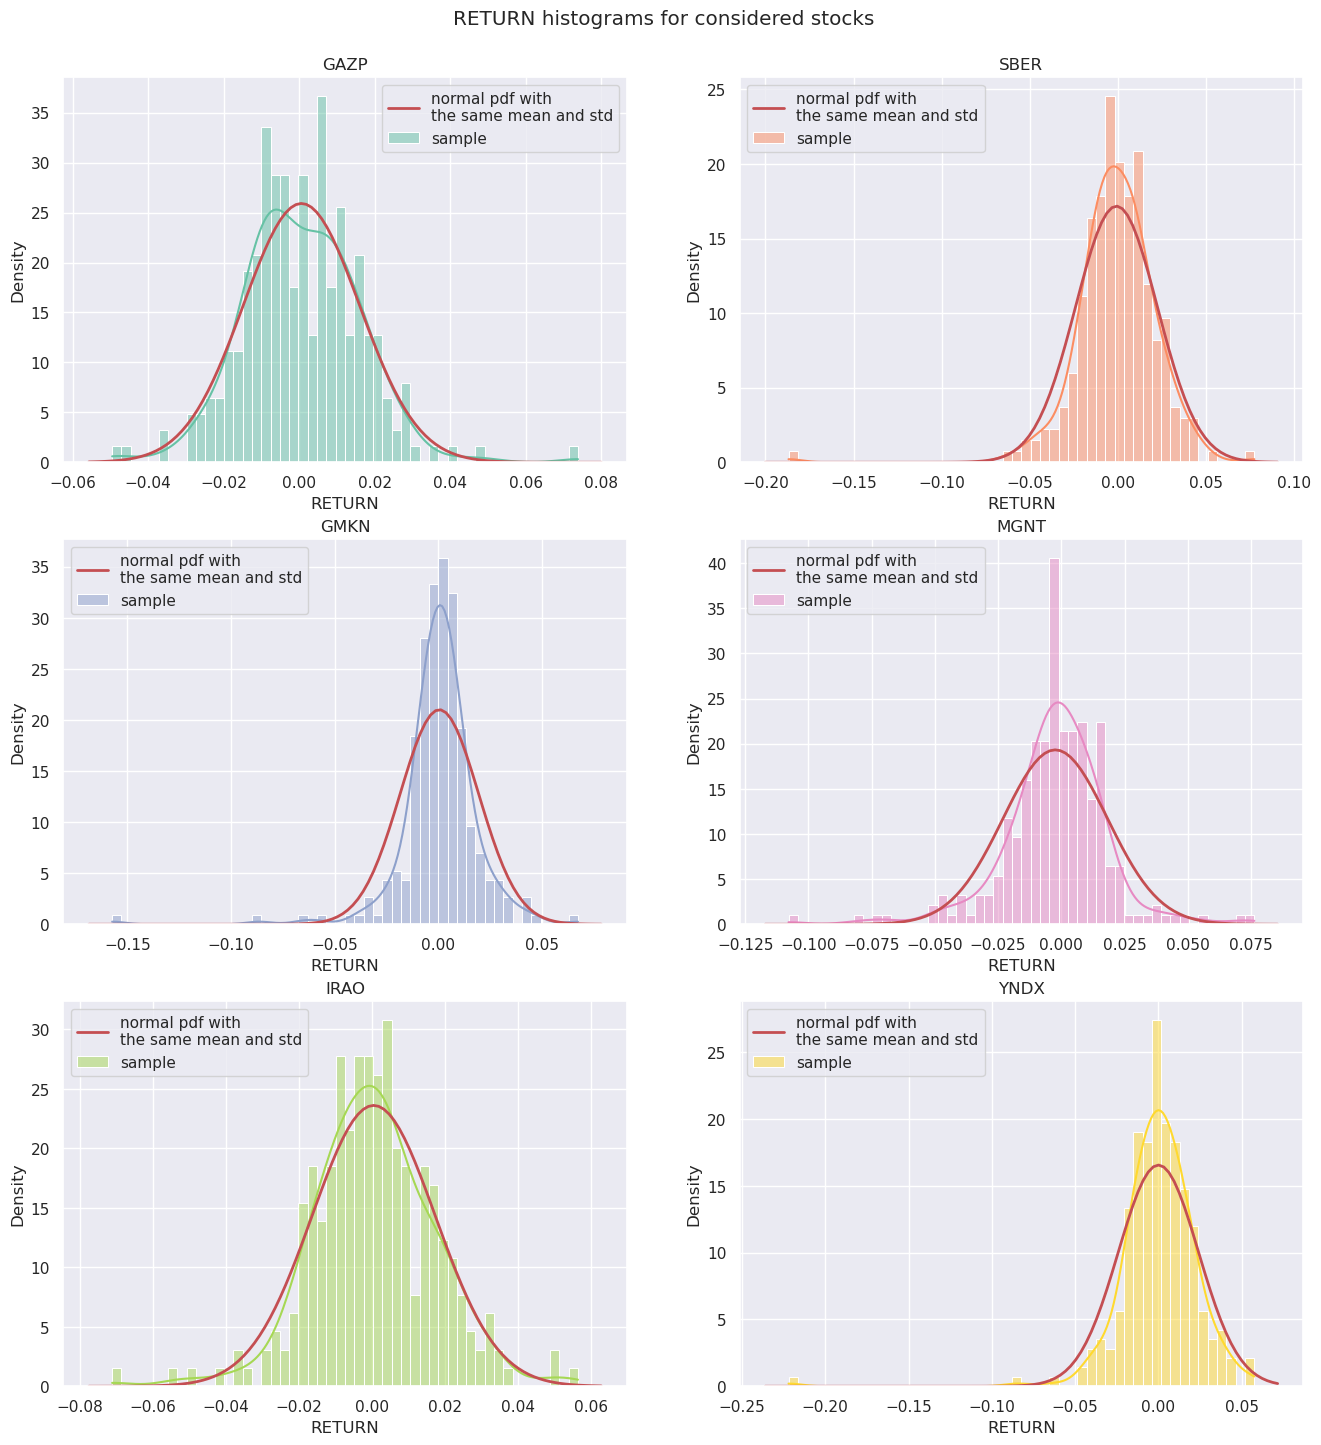

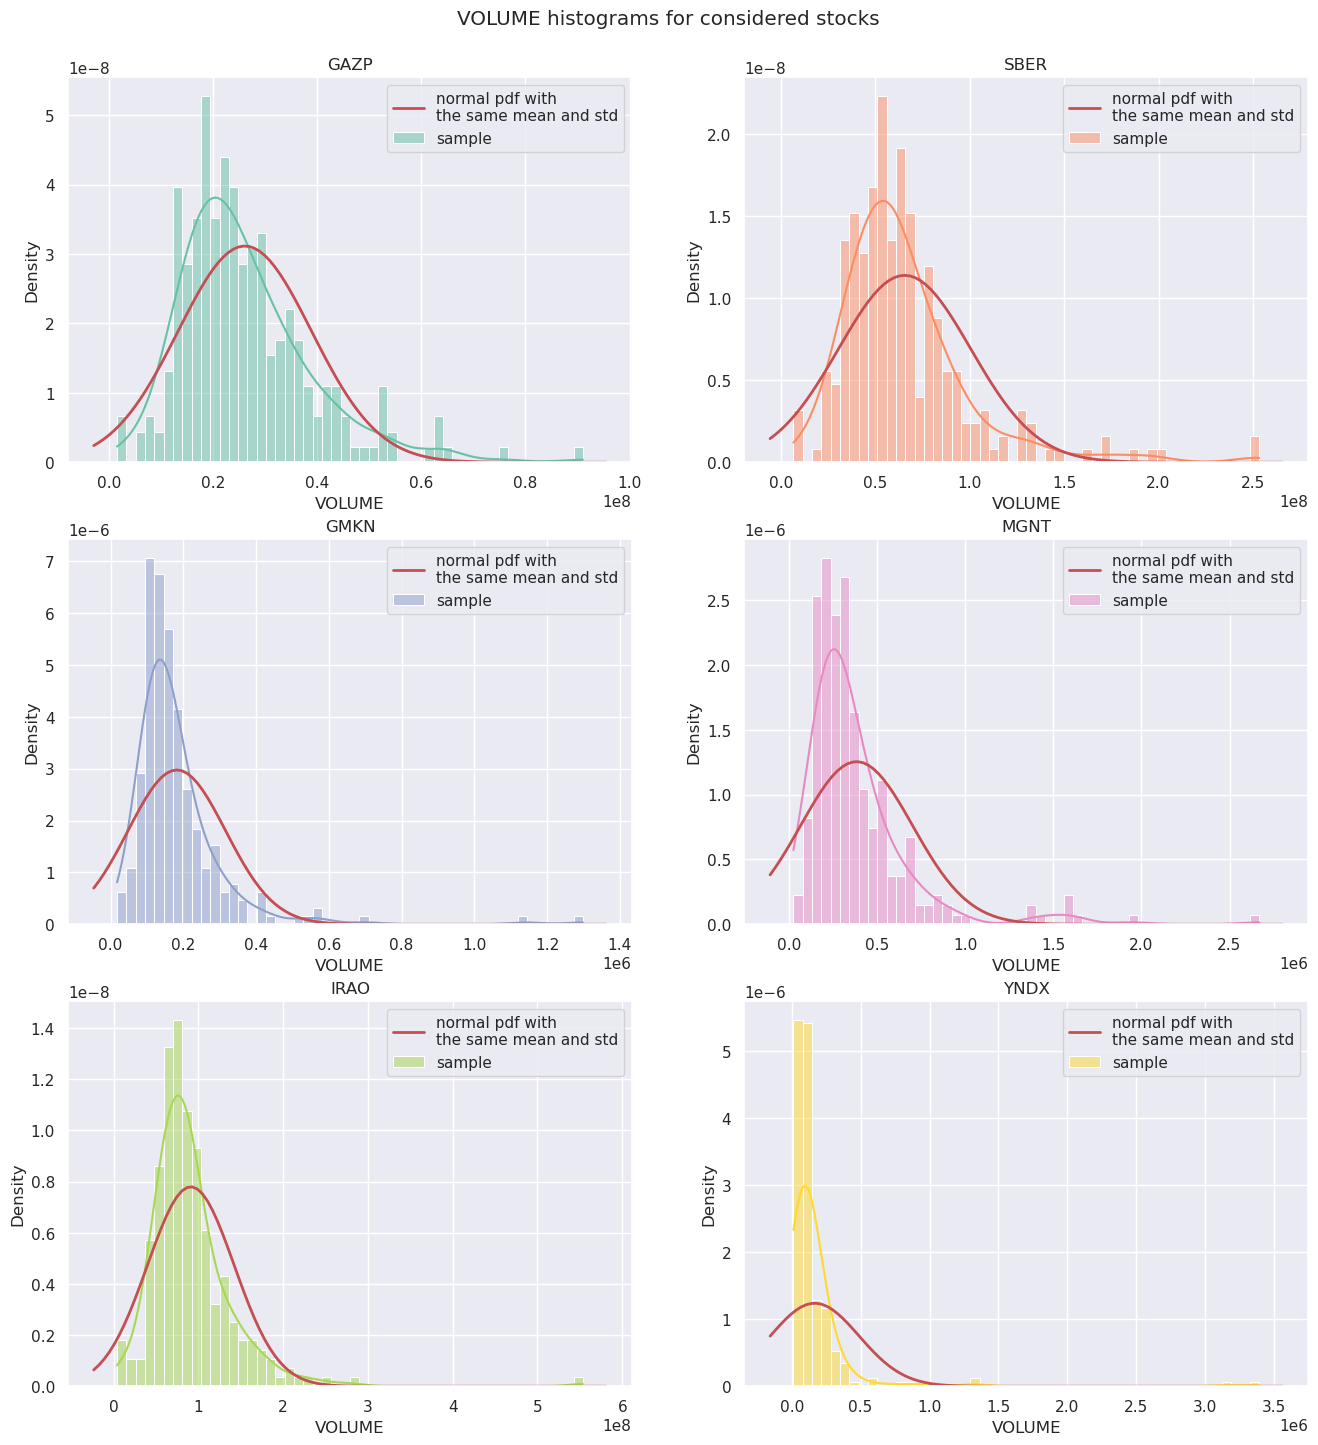

In [50]:
def plot_hists_for_distribution_test(df, column, stock_list):
    sns.set(style="darkgrid")
    colors = sns.color_palette('Set2')
    nrows, ncols = 3, 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 17))

    for i in range(nrows):
        for j in range(ncols):
            
            data_to_plot = df[df.SECID == stock_list[i*ncols+j]]
            
            g = sns.histplot(x=data_to_plot[column], kde=True, bins=50, color=colors[i*ncols+j], ax=ax[i, j], stat='density', label='sample')
            
            x0, x1 = g.get_xlim() 
            x_pdf = np.linspace(x0, x1, 100)
            y_pdf = stats.norm.pdf(x_pdf, loc=data_to_plot[column].mean(),
                                scale=data_to_plot[column].std())

            g.plot(x_pdf, y_pdf, 'r', lw=2, label=f'normal pdf with\nthe same mean and std')                                                   
            g.legend()
            g.set(title=stock_list[i*ncols+j])
            
    fig.suptitle(f'{column} histograms for considered stocks', y=0.92)
    plt.show()
    
plot_hists_for_distribution_test(data_with_return, 'RETURN', stocks_to_analyze)
plot_hists_for_distribution_test(data_with_return, 'VOLUME', stocks_to_analyze)

На графиках красным цветом построена функция плотности нормального распределения с средним и стандартным отклонением, вычисленными по выборке логарифмической доходности или объёма продаж для каждой акции. Гистограммы объёмов продаж однозначно не похожи на нормальное распределение,  а по гистограммам лог.доходности не можем утверждать точно (распределение колоколообразно, но относительно далеко от настоящего нормального с теми же параметрами).

Попробуем другой графический метод проверки на нормальность: Q-Q plot. 

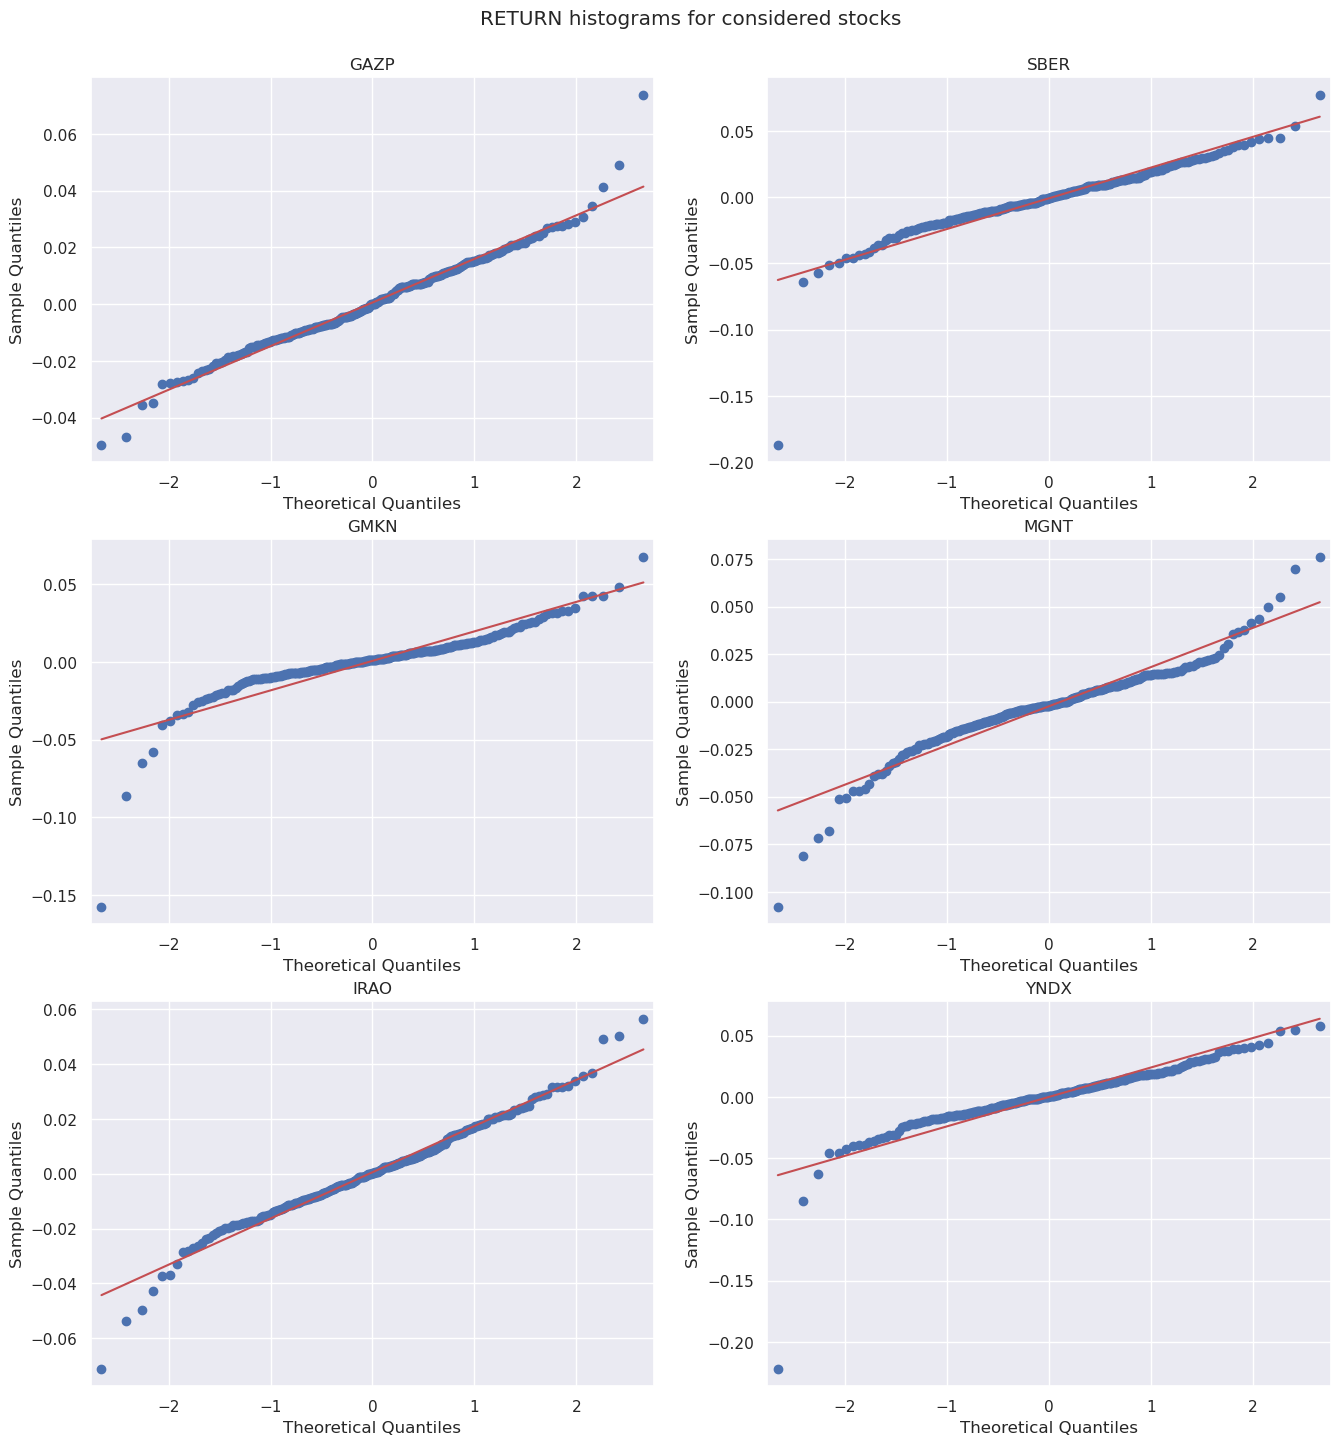

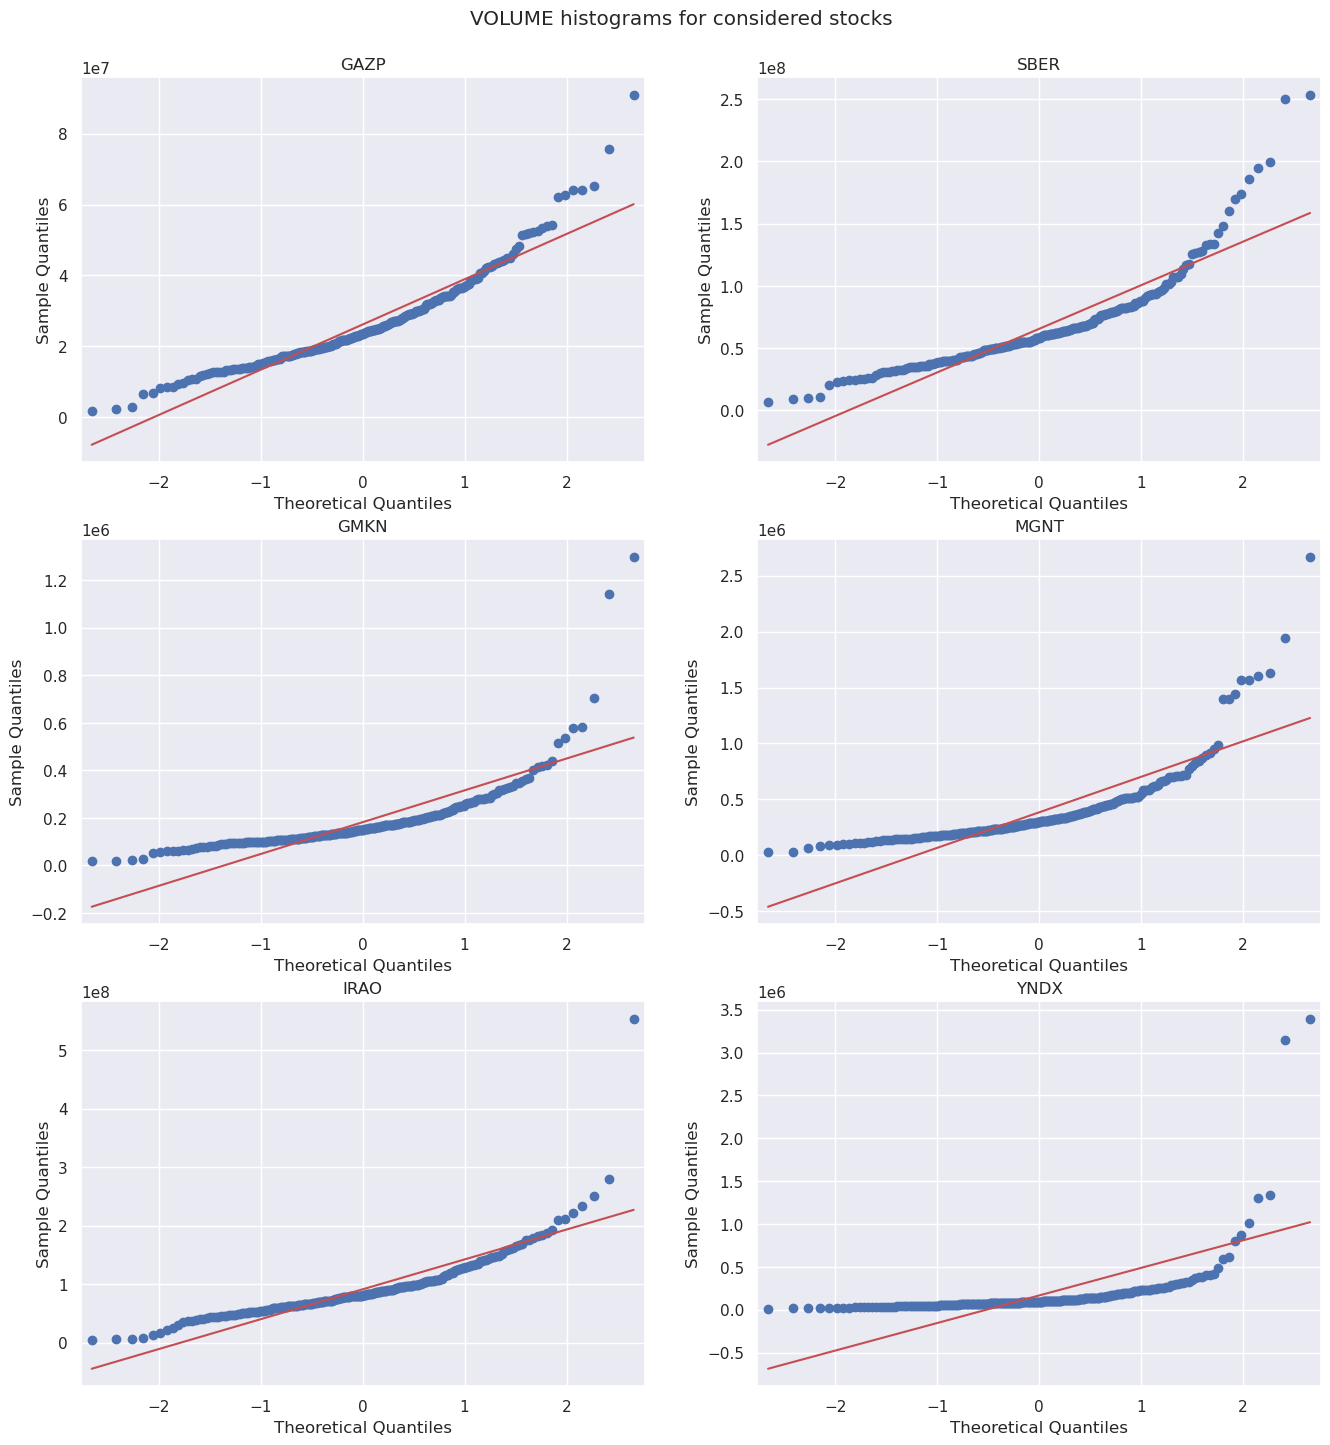

In [51]:
def plot_qq_for_distribution_test(df, column, stock_list):
    sns.set(style="darkgrid")
    nrows, ncols = 3, 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 17))

    for i in range(nrows):
        for j in range(ncols):
            g = sm.qqplot(df[df.SECID == stock_list[i*ncols+j]][column], line='s', ax=ax[i, j])
            ax[i, j].set(title=stock_list[i*ncols+j])
    
    fig.suptitle(f'{column} histograms for considered stocks', y=0.92)
    plt.show()
    
plot_qq_for_distribution_test(data_with_return, 'RETURN', stocks_to_analyze)
plot_qq_for_distribution_test(data_with_return, 'VOLUME', stocks_to_analyze)

Q-Q plots для акций GAZP, SBER, IRAO показывают, что распределение доходностей этих акций близко к нормальному распределению (мешают "хвосты"). Квантиль-квантиль графики для других акций показывают, что распределение далеко от нормального (не соответствует линии главного тренда). Насчет распределений объемов продаж можем утверждать, что они имеют не нормальное распределение для всех рассматриваемых акций. 

Проверим нормальность с помощью статистических тестов:

In [52]:
def normal_distribution_test(
    data : Any, 
    stock_name : str, 
    value_name : str, 
    alpha :float = 0.05) -> None:
    
    tests = {"D'Agostino and Pearson test" : normaltest,
         'Shapiro-Wilk test' : shapiro,
         "Kolmogorov-Smirnov test" : kstest,
         "Anderson-Darling test" : normal_ad}
    
    result_dict = {"stock": [], "value" : [], "test_name" : [], "pvalue": [], "result": []}
    
    for test_name, test_callable in tests.items():
        if test_name == "Kolmogorov-Smirnov test":
            statistic, pvalue = test_callable(data, "norm", args=(data.mean(), data.std()))

        else:
            statistic, pvalue = test_callable(data)
            
        result_dict['stock'].append(stock_name)
        result_dict['value'].append(value_name)
        result_dict['test_name'].append(test_name)
        result_dict['pvalue'].append(f"{pvalue:.5f}")
        
        if pvalue > alpha:
            result_dict['result'].append('Не отвергается')
        else:
            result_dict['result'].append('Отвергается')
    
    return result_dict
            
def get_tests_results(
    stock_list : Any, 
    df : pd.DataFrame, 
    alpha : float = 0.05) -> None:

    result = pd.DataFrame(columns=['stock', 'value', 'test_name', 'pvalue', 'result'])
    
    for stock in stock_list:
        result_return = normal_distribution_test(df[df.SECID == stock].RETURN.values, stock, "log.return")
        result_volume = normal_distribution_test(df[df.SECID == stock].VOLUME.values, stock,"volume")

        result = pd.concat([result, pd.DataFrame(result_return), pd.DataFrame(result_volume)], axis=0, ignore_index=True)
    
    return result

get_tests_results(stocks_to_analyze, data_with_return)

stock       value                    test_name   pvalue          result
0   GAZP  log.return  D'Agostino and Pearson test  0.00005     Отвергается
1   GAZP  log.return            Shapiro-Wilk test  0.00088     Отвергается
2   GAZP  log.return      Kolmogorov-Smirnov test  0.81956  Не отвергается
3   GAZP  log.return        Anderson-Darling test  0.09456  Не отвергается
4   GAZP      volume  D'Agostino and Pearson test  0.00000     Отвергается
5   GAZP      volume            Shapiro-Wilk test  0.00000     Отвергается
6   GAZP      volume      Kolmogorov-Smirnov test  0.00566     Отвергается
7   GAZP      volume        Anderson-Darling test  0.00000     Отвергается
8   SBER  log.return  D'Agostino and Pearson test  0.00000     Отвергается
9   SBER  log.return            Shapiro-Wilk test  0.00000     Отвергается
10  SBER  log.return      Kolmogorov-Smirnov test  0.10524  Не отвергается
11  SBER  log.return        Anderson-Darling test  0.00000     Отвергается
12  SBER      volume  D'Agostino and Pearson test  0.00000     Отвергается
13  SBER      volume            Shapiro-Wilk test  0.00000     Отвергается
14  SBER      volume      Kolmogorov-Smirnov test  0.00001     Отвергается
15  SBER      volume        Anderson-Darling test  0.00000     Отвергается
16  GMKN  log.return  D'Agostino and Pearson test  0.00000     Отвергается
17  GMKN  log.return            Shapiro-Wilk test  0.00000     Отвергается
18  GMKN  log.return      Kolmogorov-Smirnov test  0.00002     Отвергается
19  GMKN  log.return        Anderson-Darling test  0.00000     Отвергается
20  GMKN      volume  D'Agostino and Pearson test  0.00000     Отвергается
21  GMKN      volume            Shapiro-Wilk test  0.00000     Отвергается
22  GMKN      volume      Kolmogorov-Smirnov test  0.00000     Отвергается
23  GMKN      volume        Anderson-Darling test  0.00000     Отвергается
24  MGNT  log.return  D'Agostino and Pearson test  0.00000     Отвергается
25  MGNT  log.return            Shapiro-Wilk test  0.00000     Отвергается
26  MGNT  log.return      Kolmogorov-Smirnov test  0.03635     Отвергается
27  MGNT  log.return        Anderson-Darling test  0.00000     Отвергается
28  MGNT      volume  D'Agostino and Pearson test  0.00000     Отвергается
29  MGNT      volume            Shapiro-Wilk test  0.00000     Отвергается
30  MGNT      volume      Kolmogorov-Smirnov test  0.00000     Отвергается
31  MGNT      volume        Anderson-Darling test  0.00000     Отвергается
32  IRAO  log.return  D'Agostino and Pearson test  0.00101     Отвергается
33  IRAO  log.return            Shapiro-Wilk test  0.00148     Отвергается
34  IRAO  log.return      Kolmogorov-Smirnov test  0.69711  Не отвергается
35  IRAO  log.return        Anderson-Darling test  0.02977     Отвергается
36  IRAO      volume  D'Agostino and Pearson test  0.00000     Отвергается
37  IRAO      volume            Shapiro-Wilk test  0.00000     Отвергается
38  IRAO      volume      Kolmogorov-Smirnov test  0.00002     Отвергается
39  IRAO      volume        Anderson-Darling test  0.00000     Отвергается
40  YNDX  log.return  D'Agostino and Pearson test  0.00000     Отвергается
41  YNDX  log.return            Shapiro-Wilk test  0.00000     Отвергается
42  YNDX  log.return      Kolmogorov-Smirnov test  0.00773     Отвергается
43  YNDX  log.return        Anderson-Darling test  0.00000     Отвергается
44  YNDX      volume  D'Agostino and Pearson test  0.00000     Отвергается
45  YNDX      volume            Shapiro-Wilk test  0.00000     Отвергается
46  YNDX      volume      Kolmogorov-Smirnov test  0.00000     Отвергается
47  YNDX      volume        Anderson-Darling test  0.00000     Отвергается

В результате получается, что тесты Колмогорова-Смиронова и Андерсона-Дарлинга не отвергают гипотезу о нормальности распределения доходностей "Газпрома" GAZP, 
тесты Колмогорова-Смиронова не отвергают гипотезу о нормальности распределения доходностей "Сбера" SBER и "Интер РАО ЕЭС" IRAO, в остальных случаях гипотезы о нормальности отвергнуты.

# Задание 8

Исследовать	зависимости (выборочно) между доходностями	различных активов с помощью техники	анализа зависимостей. Сделайте анализ	зависимостей между парами активов для	активов из одного производственного	сектора и для активов из разных	производственных секторов. Сделайте	анализ зависимости (выборочно) между	доходностями и объемами продаж одного	актива. Рассмотрите активы из разных	производственных секторов.

In [53]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16', parse_dates=["TRADEDATE"])

In [54]:
def dependence_test(
    stocks: List[str],
    df: pd.DataFrame,
    metric_col_X: str="RETURN",
    metric_col_Y: str="RETURN",
    alpha: float=0.05,
) -> pd.DataFrame:
    connection_dict = {"X": [], "Y": [], "hypothesis": []}
    for i, stock_1 in enumerate(stocks):
        for j, stock_2 in enumerate(stocks):
            if j <= i:
                continue
            statistic, p = ttest_ind(df[df.SECID == stock_1][metric_col_X], df[df.SECID == stock_2][metric_col_Y], equal_var=False)
            connection_dict["X"].append(stock_1)
            connection_dict["Y"].append(stock_2)
            
            verdict = np.nan
            if p > ALPHA:
                verdict = "accepted"
            else:
                verdict = "rejected"
            connection_dict["hypothesis"].append(verdict)
    return pd.DataFrame(connection_dict)

Расммотрим нефтегазовую и строительную отрасль

In [57]:
oil_stocks = ["LKOH", "TRNFP", "TATNP", "ROSN", "NVTK"]
dependence_test(oil_stocks, df, alpha=ALPHA)

X      Y hypothesis
0   LKOH  TRNFP   accepted
1   LKOH  TATNP   accepted
2   LKOH   ROSN   accepted
3   LKOH   NVTK   accepted
4  TRNFP  TATNP   accepted
5  TRNFP   ROSN   accepted
6  TRNFP   NVTK   accepted
7  TATNP   ROSN   accepted
8  TATNP   NVTK   accepted
9   ROSN   NVTK   accepted

In [58]:
building_stocks = ["LSRG", "PIKK"]
dependence_test(building_stocks, df, alpha=ALPHA)

X     Y hypothesis
0  LSRG  PIKK   accepted

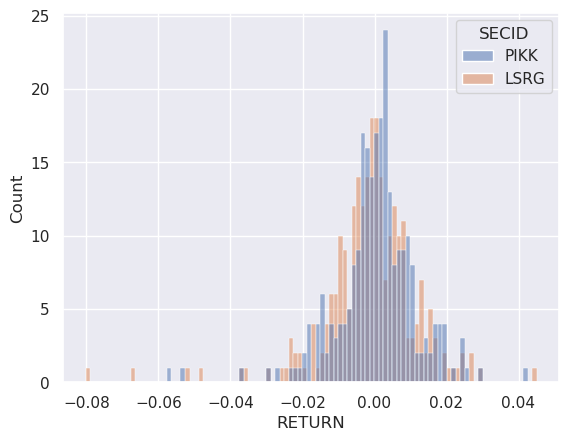

In [59]:
sns.histplot(data=df[df.SECID.isin(building_stocks)], x="RETURN", hue="SECID", bins=100);

Видим, что гипотеза однородности принимается для активов из одинаковых секторов. 

Теперь проверим разные сектора:

In [62]:
oil_stock = ["LKOH"]
building_stock = ["LSRG"]
dependence_test(oil_stock + building_stock, df, alpha=ALPHA)

X     Y hypothesis
0  LKOH  LSRG   rejected

Посмотрим выполняется проверка на однородность дохода и объема у одного из активов:

In [69]:
dependence_test(["LKOH", "LKOH"], df, metric_col_X="RETURN", metric_col_Y="VOLUME", alpha=ALPHA)

X     Y hypothesis
0  LKOH  LKOH   rejected

Посмотрим еще на матрицу корреляций двух секторов

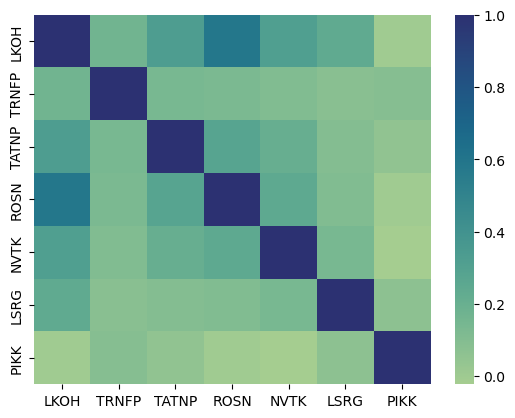

In [95]:
all_df = dict()
for stock in oil_stocks + building_stocks:
    stock_returns = df[df.SECID == stock].sort_values(by="TRADEDATE").RETURN.to_list()
    all_df[stock] = stock_returns
all_df = pd.DataFrame(all_df)

sns.heatmap(all_df.corr(), cmap="crest");

Можно заметить, что участки карты активов общих секторов будут слегка темнее, чем из разных (нижняя строчка и крайняя правая).

Самая сильняя корреляция у `ROSN` и `LKOH`, т.е. у Лукойла и Роснефти соответсвенно.

In [73]:
pio.renderers.default = 'pdf'

In [74]:
!jupyter nbconvert --to html lab1.ipynb

[NbConvertApp] Converting notebook lab1.ipynb to html
[NbConvertApp] Writing 4692034 bytes to lab1.html
